## 0 - IMPORTAÇAO DAS BIBLIOTECAS

In [214]:
import math
import pandas as pd
import inflection
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# A biblioteca Sklearn mudou o nome e passou a se chamar scikit-learn -> pip install scikit-learn

from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from scipy import stats
from IPython.core.display import HTML
from IPython.display import Image
import datetime

In [139]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# Logo abaixo fazendo a junção com o Merge

df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )


## 1 - Copia dos Dados

In [140]:
## Copia dos dados

df1 = df_raw.copy()

In [141]:
df_raw.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [142]:
## Aqui pode ler o dataframe com o comando sample para vir qualquer numero aleatorio 

df_raw.sample(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
798980,311,1,2013-07-15,8684,856,1,1,0,1,a,c,680.0,7.0,2005.0,0,NaN,NaN,NaN
199081,612,2,2015-02-03,7362,424,1,1,0,0,d,c,2490.0,11.0,2012.0,1,31.0,2009.0,"Jan,Apr,Jul,Oct"
366135,869,5,2014-08-15,4012,743,1,0,0,1,c,a,230.0,10.0,2001.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
616694,885,4,2013-12-26,0,0,0,0,c,1,a,a,480.0,12.0,2005.0,0,NaN,NaN,NaN
95417,643,4,2015-05-07,8301,989,1,1,0,0,a,a,230.0,6.0,2010.0,1,18.0,2010.0,"Feb,May,Aug,Nov"


## 1.1 - Renomear as Colunas

In [143]:
## Exibe os nomes das colunas

df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [144]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new

In [145]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 - Dimensao do Dataframe

In [146]:
print ('O numero total de linhas são: {}'.format(df1.shape[0]))
print ('O numero total de colunas são: {}'.format(df1.shape[1]))

O numero total de linhas são: 1017209
O numero total de colunas são: 18


## 1.3 - Tipos de dados

In [147]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 - Check de NA

In [148]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 - Tratamento dos NA ou Seja ( Não Aplicada) - Dados faltantes

In [149]:
df1['competition_distance'].max()

75860.0

In [150]:
#competition_distance              
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan (x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year     
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan (x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week               
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan (x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year               
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan (x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval                  
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1) 


In [151]:
df1.sample(5).T

,828095,522955,490598,801210,133972
store,436,806,784,311,173
day_of_week,3,4,5,6,4
date,2013-06-19 00:00:00,2014-03-20 00:00:00,2014-04-18 00:00:00,2013-07-13 00:00:00,2015-04-02 00:00:00
sales,5443,6380,0,4553,11910
customers,593,496,0,533,1274
open,1,1,0,1,1
promo,1,1,1,0,1
state_holiday,0,0,b,0,0
school_holiday,0,0,1,1,1
store_type,d,d,a,a,a


## 1.6 - Change Types

In [152]:
## Mudando algumas colunas para inteiro, pois estavam como float

df1['competition_open_since_month'] = df1['competition_open_since_month'].astype (int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype (int)

df1['promo2_since_year'] = df1['promo2_since_year'].astype (int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype (int)

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 - Estatistica descritiva

In [153]:
num_attributes = df1.select_dtypes(include=['int64', 'int32', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'int32', 'float64', 'datetime64[ns]'])

In [154]:
# Variaveis numericas
num_attributes.sample(2)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
576756,1087,5,6836,618,1,0,1,2210.0,11,2011,0,5,2014,0
178760,361,6,5694,672,1,0,0,4490.0,5,2014,1,5,2013,0


In [155]:
# Variaveis Categoricas
cat_attributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
501304,0,a,c,0,Apr
632595,0,a,c,"Jan,Apr,Jul,Oct",Dec


## 1.7.1 - Atributos numericos

In [156]:
# Central e tendencia - media e mediana
ct1 = pd.DataFrame(num_attributes.apply(np.mean) ).T
ct2 = pd.DataFrame(num_attributes.apply(np.median) ).T

# Dispersão - Desvio padrão - STD, maximo, minimo, range (valor entre o minimo e maximo), Skew e Kurtose
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenar
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['Attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,Attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


C:\Users\jcmaz\AppData\Local\Temp\ipykernel_4792\710812770.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='sales', ylabel='Density'>

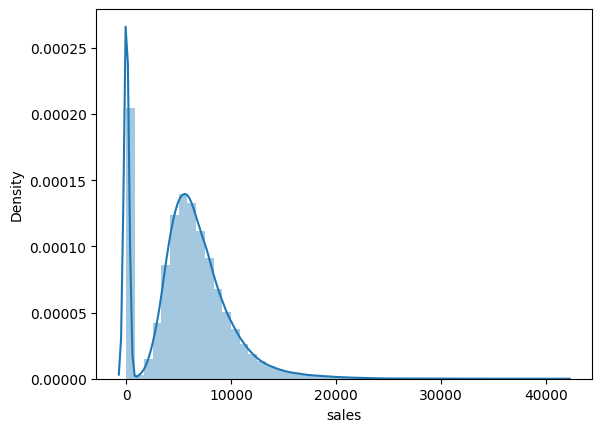

In [157]:
sns.distplot(df1['sales'])

C:\Users\jcmaz\AppData\Local\Temp\ipykernel_4792\3391210532.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




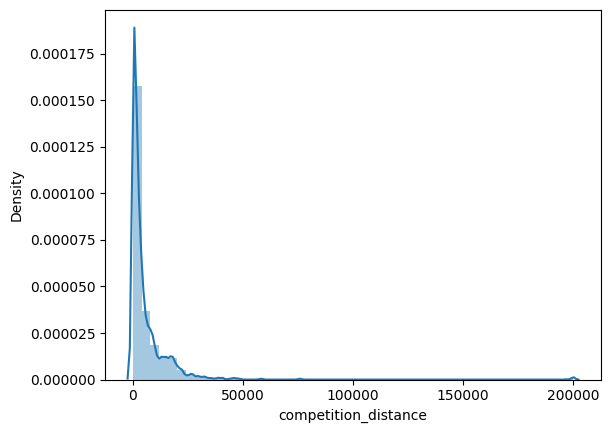

In [158]:
sns.distplot(df1['competition_distance']);

## 1.7.2 - Dados Categoricos

In [159]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

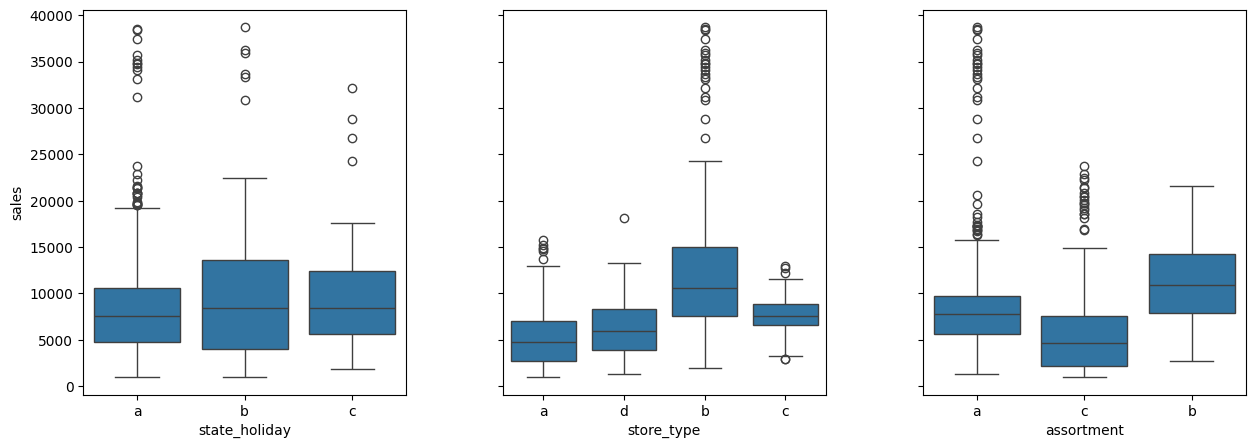

In [160]:
# Crie uma figura com subplots e defina o tamanho da figura e o espaçamento horizontal
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.subplots_adjust(wspace=0.3)  # Ajuste o espaçamento horizontal

# Seu código para os subplots
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

sns.boxplot(x='state_holiday', y='sales', data=aux1, ax=axes[0])  # Usando o primeiro subplot
sns.boxplot(x='store_type', y='sales', data=aux1, ax=axes[1])  # Usando o segundo subplot
sns.boxplot(x='assortment', y='sales', data=aux1, ax=axes[2])  # Usando o terceiro subplot

plt.show()

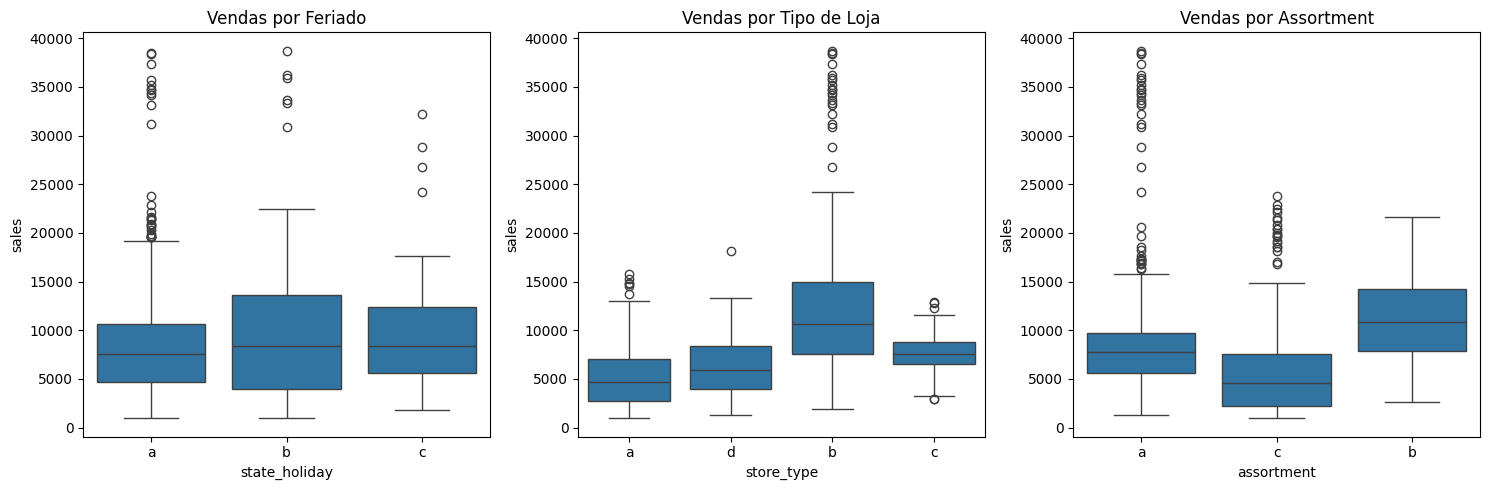

In [161]:
# Filtrar os dados
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

# Criar uma figura com 1 linha e 3 colunas
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Gráfico 1
sns.boxplot(x='state_holiday', y='sales', data=aux1, ax=axes[0])
axes[0].set_title('Vendas por Feriado')

# Gráfico 2
sns.boxplot(x='store_type', y='sales', data=aux1, ax=axes[1])
axes[1].set_title('Vendas por Tipo de Loja')

# Gráfico 3
sns.boxplot(x='assortment', y='sales', data=aux1, ax=axes[2])
axes[2].set_title('Vendas por Assortment')

# Ajustar o espaçamento entre os gráficos
plt.tight_layout()

# Exibir a figura
plt.show()

In [162]:

# Suponha que você já tem seus dados em 'df1' e 'aux1' foi criado como indicado na pergunta

# Ajuste o tamanho da figura
plt.figure(figsize=(12, 2))

# Crie os subplots com um espaçamento adequado
#plt.subplot(1, 3, 1)
#sns.boxplot(x='state_holiday', y='sales', data=aux1)
#plt.title('State Holiday')

#plt.subplot(1, 3, 2)
#sns.boxplot(x='store_type', y='sales', data=aux1)
#plt.title('Store Type')

#plt.subplot(1, 3, 3)
#sns.boxplot(x='assortment', y='sales', data=aux1)
#plt.title('Assortment')

# Ajuste o espaçamento entre os gráficos
plt.tight_layout()

# Exiba os gráficos interativamente usando Plotly


fig = px.box(aux1, x='state_holiday', y='sales')
fig.update_layout(title='State Holiday')
fig.show()

fig = px.box(aux1, x='store_type', y='sales')
fig.update_layout(title='Store Type')
fig.show()

fig = px.box(aux1, x='assortment', y='sales')
fig.update_layout(title='Assortment')
fig.show()

<Figure size 1200x200 with 0 Axes>

## 2.0 - Feature Engineering


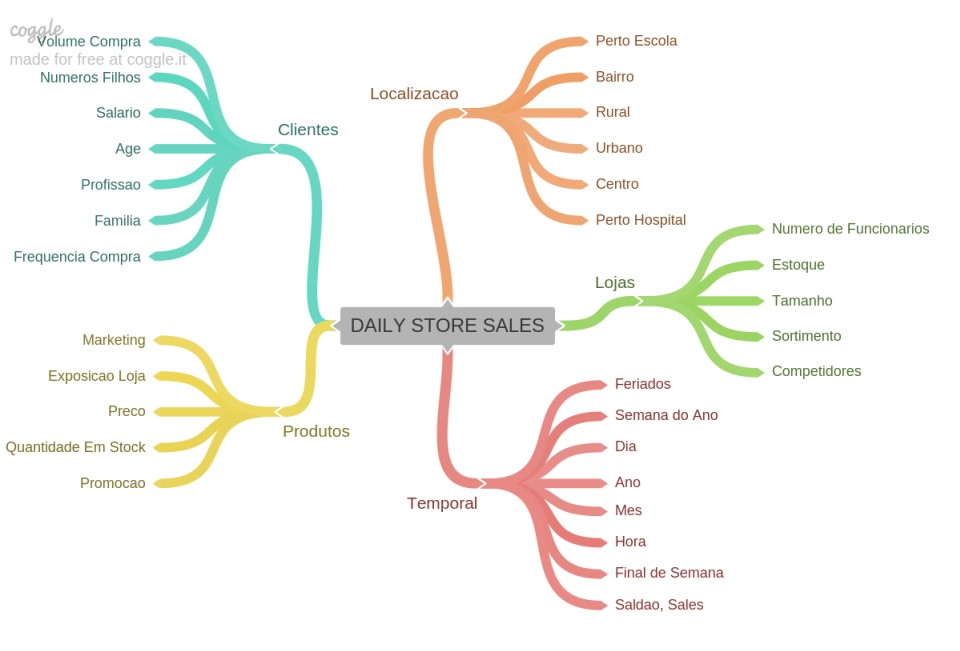

In [163]:
Image('img/mapa_mental.jpg')

In [164]:
df2 = df1.copy()

In [165]:
# - Year - Ano

df2['year'] = df2['date'].dt.year

# - Month - Mes

df2['month'] = df2['date'].dt.month

# - Day - Dia

df2['day'] = df2['date'].dt.day

# - week_of_year - Semana do ano

#df2['week_of_year'] = df2['date'].dt.weekday

# - year week - Ano da semana

df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# - Competition since

df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days ).astype(int)

# - promo since

df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w' ) - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# - Assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# - State holiday - feriados
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'Easter_holiday' if x == 'b' else 'Christmas' if x == 'c' else 'regular_day')


In [166]:
df2.head(5).T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


## 3.0 - Filtragem de variavel

In [167]:
df3 = df2.copy()

In [168]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,month_map,is_promo,year,month,day,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,Jul,0,2015,7,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,Jul,1,2015,7,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,Jul,1,2015,7,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,Jul,0,2015,7,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,Jul,0,2015,7,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 - Filtragem das linhas

In [169]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Seleção das Colunas

In [170]:
# - Limpando as colunas que não fazem relevancia no projeto

cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [171]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'year_week', 'competition_since', 'competition_time_month',
       'promo_since', 'promo_time_week'],
      dtype='object')

## 4.0 Analise Exploratoria de Dados

In [172]:
df4 = df3.copy()

## 4.1 Analise Univariada

### 4.1.1 Variaveis de Resposta

C:\Users\jcmaz\AppData\Local\Temp\ipykernel_4792\1473926699.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='sales', ylabel='Density'>

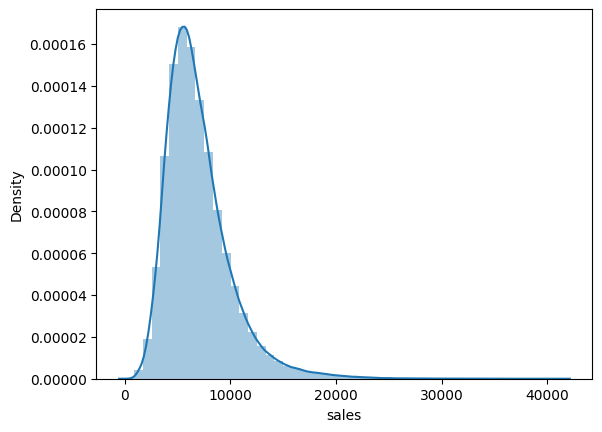

In [173]:
sns.distplot(df4['sales'])

C:\Users\jcmaz\AppData\Local\Temp\ipykernel_4792\167578569.py:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='sales', ylabel='Density'>

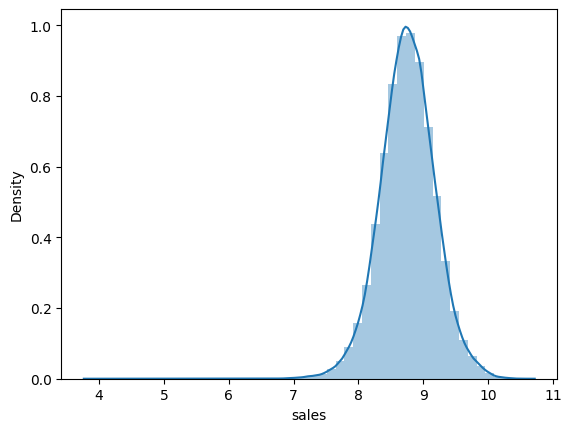

In [174]:
# Aqui utilizando o log1p para chegar mais proximo de uma variavel normal

sns.distplot(np.log1p(df4['sales']))

### 4.1.2 Variaveis Numericas

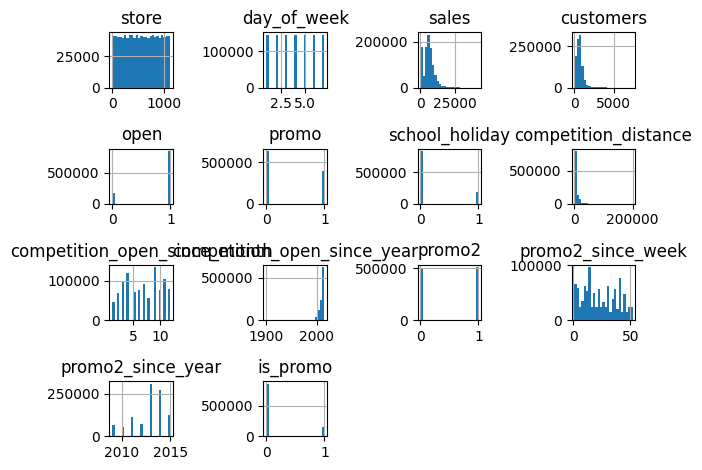

In [175]:
num_attributes.hist(bins=25);

# Ajustar espaçamento entre os subplots
plt.tight_layout()

# Mostrar os gráficos
plt.show()

C:\Users\jcmaz\AppData\Local\Temp\ipykernel_4792\2554253099.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




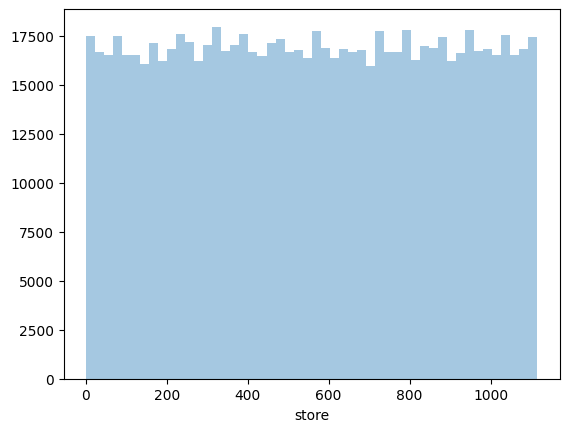

In [176]:
sns.distplot(df4['store'],kde=False); # com o kde=False ele não tras a curva

C:\Users\jcmaz\AppData\Local\Temp\ipykernel_4792\2226213634.py:11: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\jcmaz\AppData\Local\Temp\ipykernel_4792\2226213634.py:14: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\jcmaz\AppData\Local\Temp\ipykernel_4792\2226213634.py:15: UserWarning:



`distplot` is

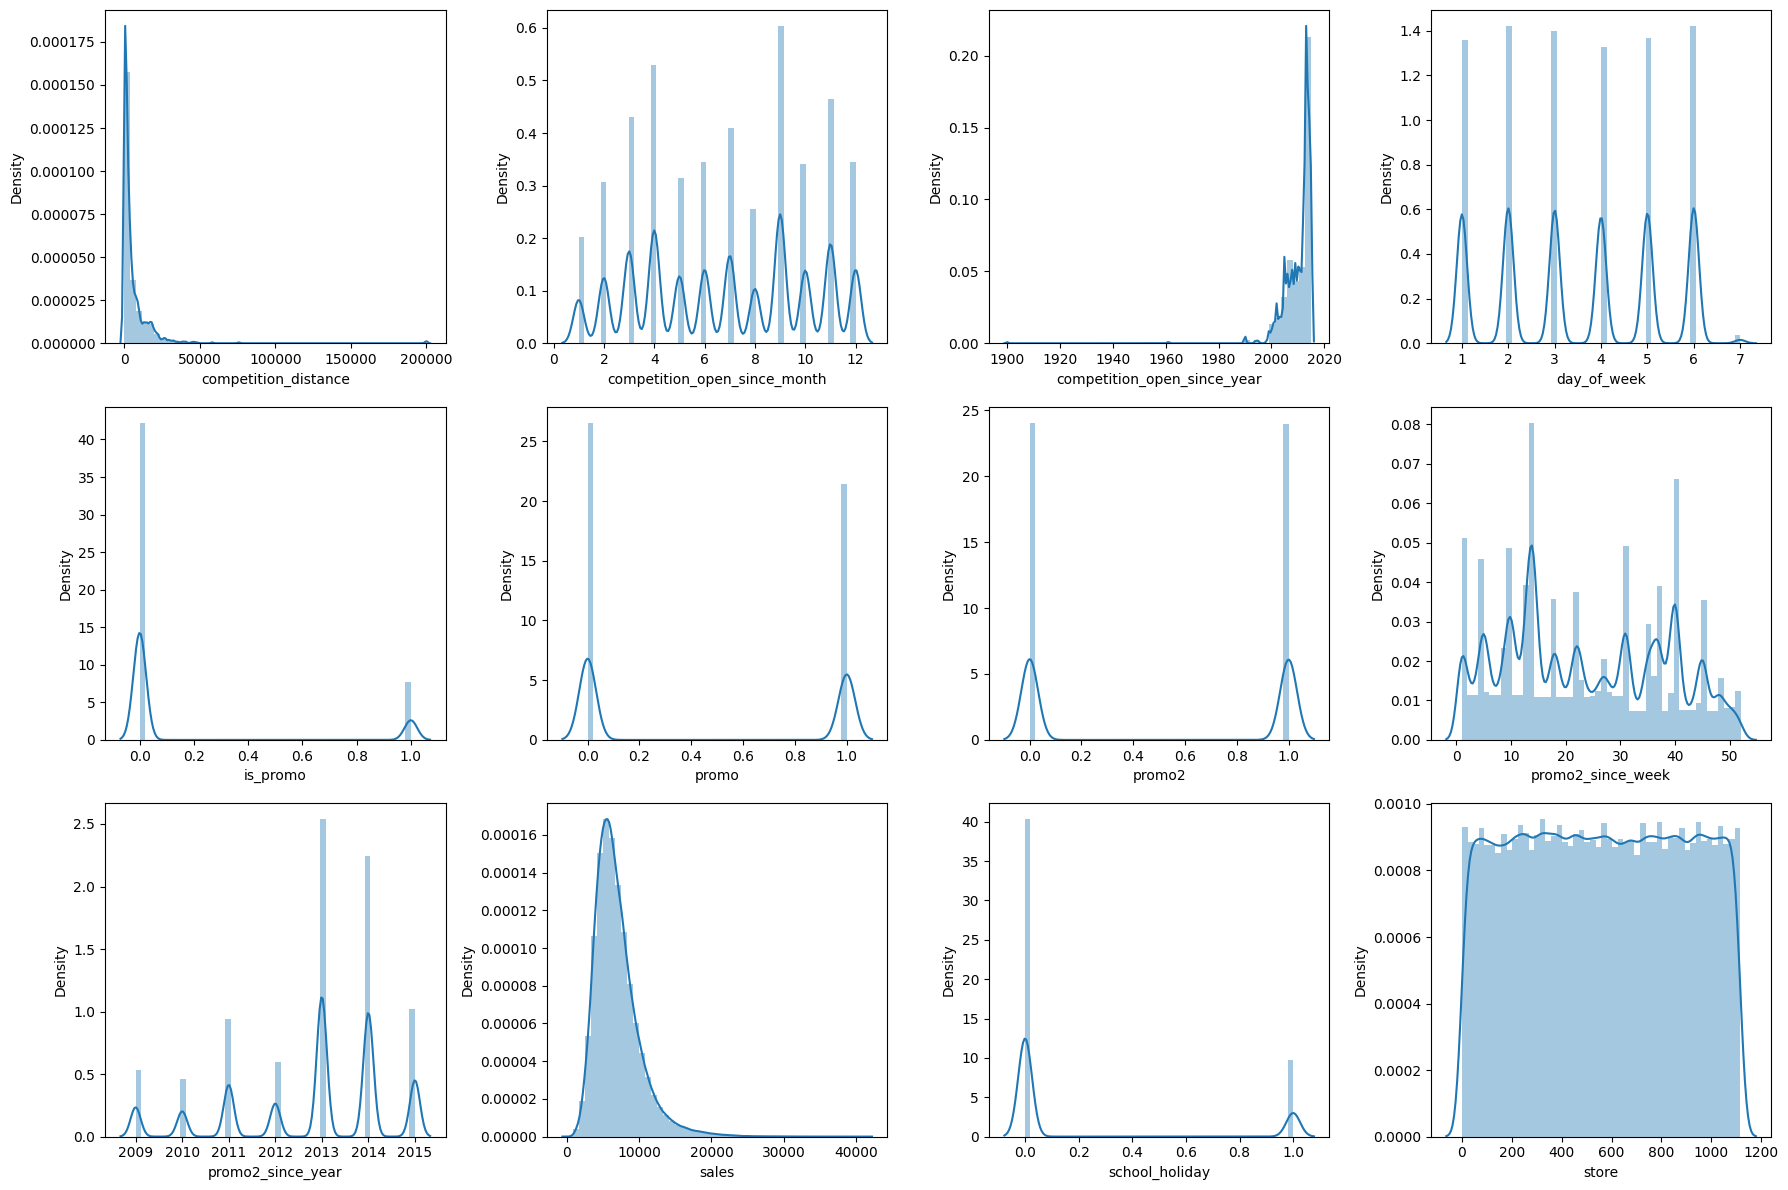

In [177]:
# Suponha que você tenha um DataFrame chamado df4 com os dados

# Crie uma figura com subplots
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 12));


# Colunas dropadas
#customers', 'open', 'promo_interval', 'month_ma

# Agora, você pode usar sns.distplot para desenhar cada gráfico em um subplot específico
sns.distplot(df4['competition_distance'], ax=axes[0, 0]);
#axes[0, 0].set_title('Distribuição da loja')

sns.distplot(df4['competition_open_since_month'], ax=axes[0, 1]);
sns.distplot(df4['competition_open_since_year'], ax=axes[0, 2]);
sns.distplot(df4['day_of_week'], ax=axes[0, 3]);
sns.distplot(df4['is_promo'], ax=axes[1, 0]);
sns.distplot(df4['promo'], ax=axes[1, 1]);
sns.distplot(df4['promo2'], ax=axes[1, 2]);
sns.distplot(df4['promo2_since_week'], ax=axes[1, 3]);
sns.distplot(df4['promo2_since_year'], ax=axes[2, 0]);
sns.distplot(df4['sales'], ax=axes[2, 1]);
sns.distplot(df4['school_holiday'], ax=axes[2, 2]);
sns.distplot(df4['store'], ax=axes[2, 3]);

# Vamos supor que você tenha mais dados para outros gráficos
# Por exemplo:
# sns.scatterplot(x=df4['coluna1'], y=df4['coluna2'], ax=axes[0, 1])
# axes[0, 1].set_title('Gráfico de dispersão')

# Você pode adicionar mais gráficos conforme necessário

# Ajuste o layout para evitar sobreposição de rótulos
plt.tight_layout();

# Exiba a figura
plt.show();

### 4.1.3 Variaveis Categoricas

In [178]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [179]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    Easter_holiday
241126         Christmas
Name: state_holiday, dtype: object

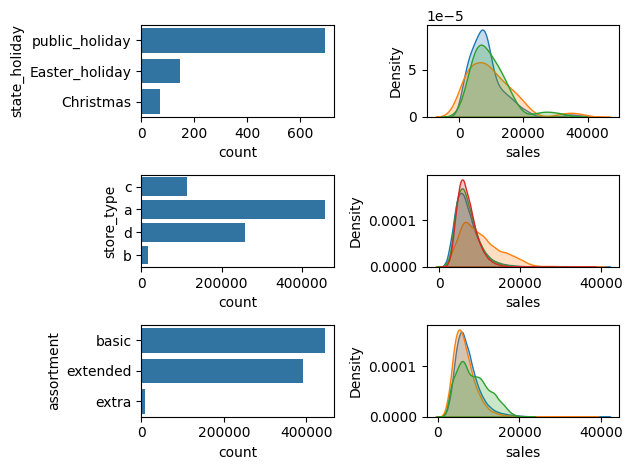

In [180]:
# State Holidays

plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'Easter_holiday']['sales'], label='Easter_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'Christmas']['sales'], label='Christmas', fill=True)

# Store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', fill=True)


# Assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True)


# Ajuste o layout para evitar sobreposição de rótulos
plt.tight_layout()

# Exiba a figura
plt.show()


## 4.2 Analise Bivariada

### H1 - As lojas que tem um mix mais variado de produtos deveriam vender mais ?
#### FALSO --> Resposta lojas que tem um maior mix na verdade são as que vendem menos

C:\Users\jcmaz\AppData\Local\Temp\ipykernel_4792\560123680.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




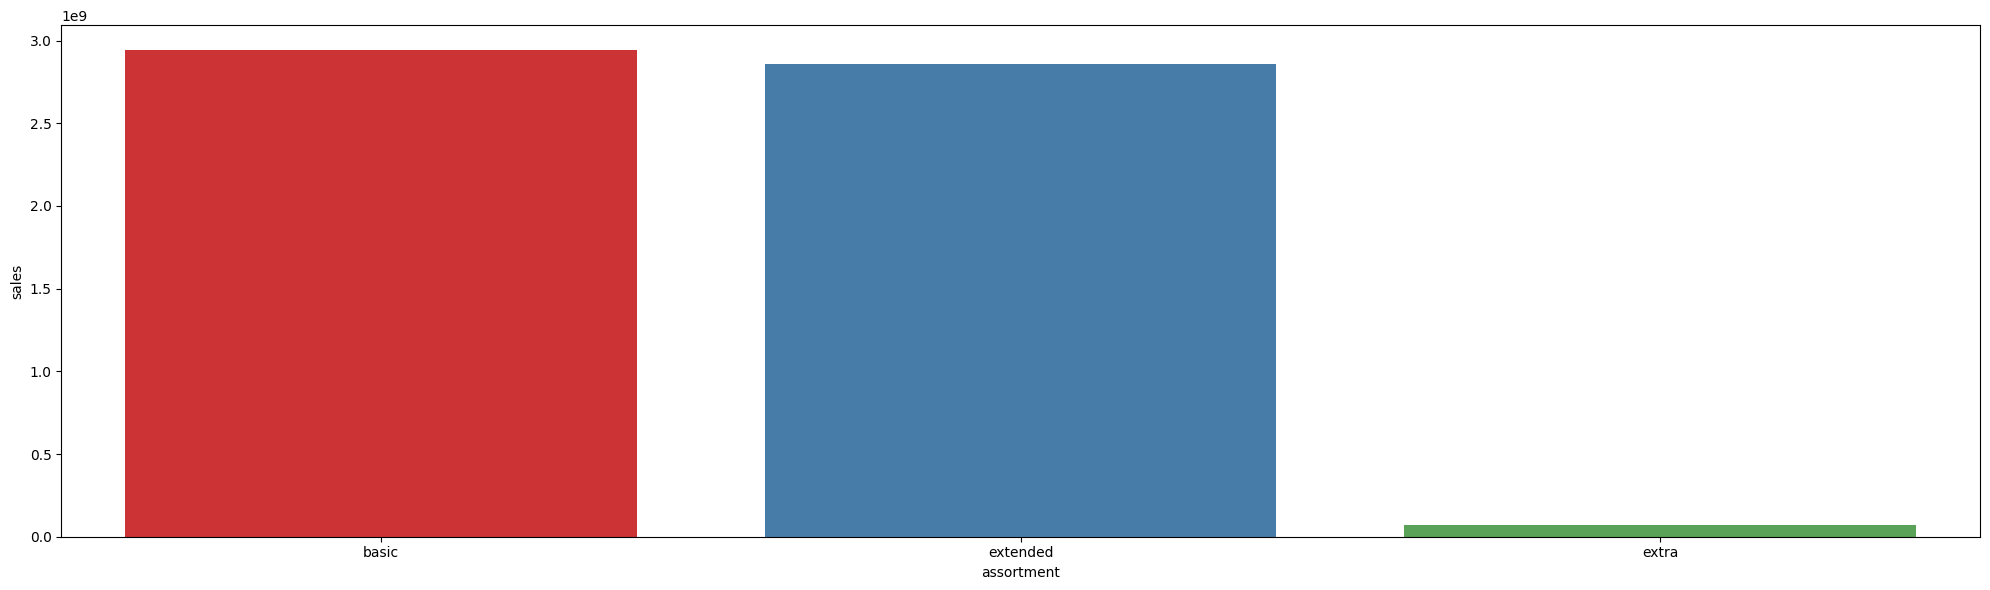

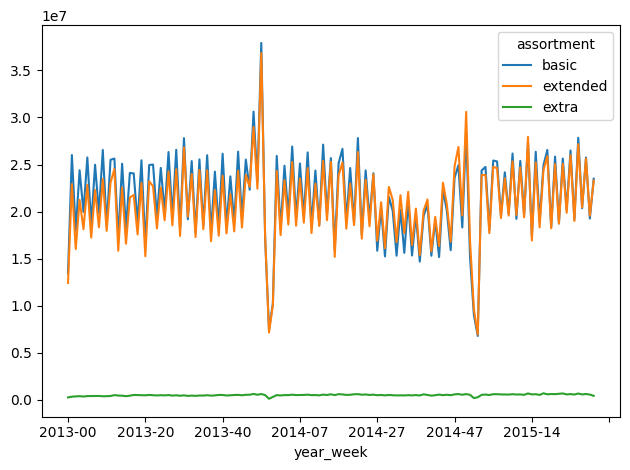

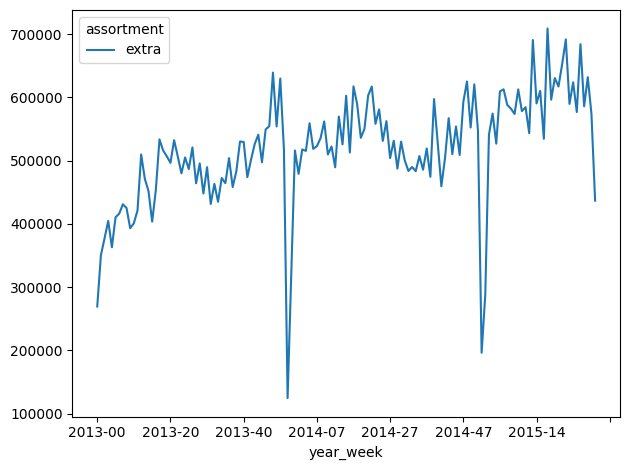

In [181]:
# As lojas que tem um mix mais variado de produtos deveriam vender mais ?

# - FALSO --> Resposta lojas que tem um maior mix na verdade são as que vendem menos

# Defina sua paleta de cores personalizada como uma lista de cores

aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()

plt.figure(figsize=(20, 6))
sns.barplot(x='assortment', y='sales', data=aux1, palette='Set1');

# Ajuste o layout para evitar sobreposição de rótulos
plt.tight_layout()

# Exiba a figura
plt.show()

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

# Ajuste o layout para evitar sobreposição de rótulos
plt.tight_layout()

# Exiba a figura
plt.show()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

# Ajuste o layout para evitar sobreposição de rótulos
plt.tight_layout()

# Exiba a figura
plt.show()

### H2 - Lojas com competidores mais proximos deveriam vender menos

#### FALSA - Lojas com COMPETIDORES mais proximos vendem MAIS

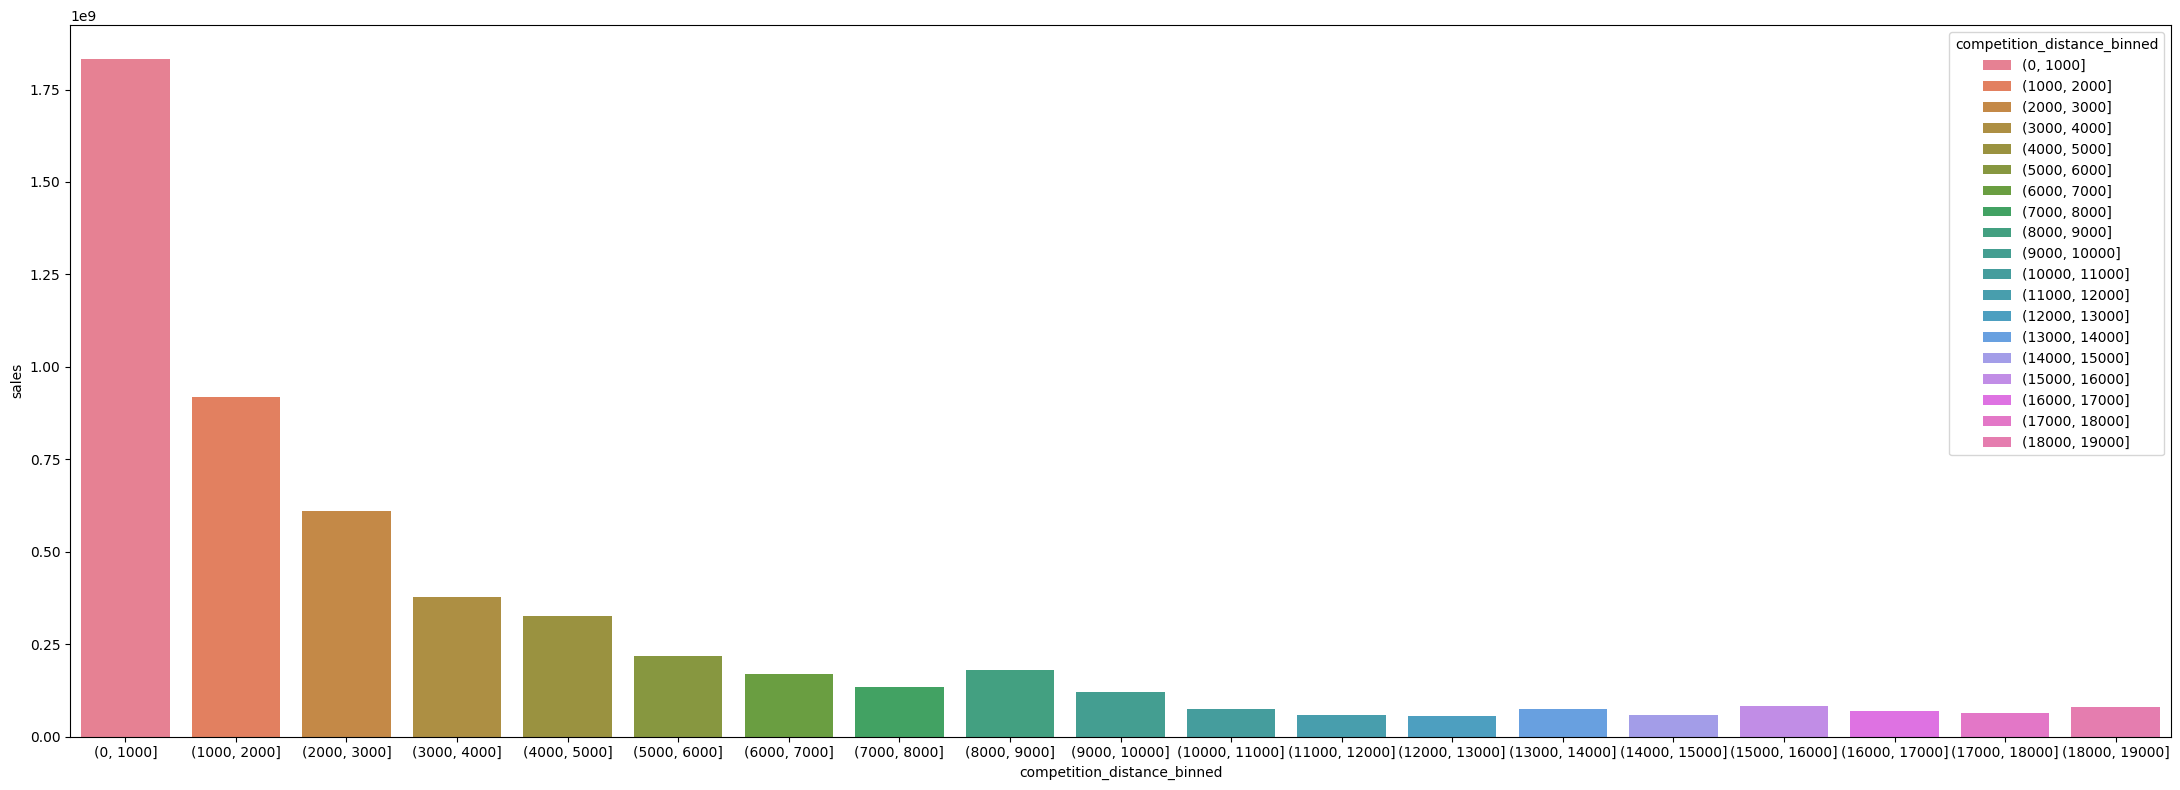

In [182]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

bins = list(np.arange(0, 20000, 1000))

aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()


plt.figure(figsize=(22, 8))
#sns.barplot(x='competition_distance_binned', y='sales', data=aux2, palette='Set1');
sns.barplot(x='competition_distance_binned', y='sales', data=aux2, hue='competition_distance_binned');
# Ajuste o layout para evitar sobreposição de rótulos
plt.tight_layout()

# Exiba a figura
plt.show()

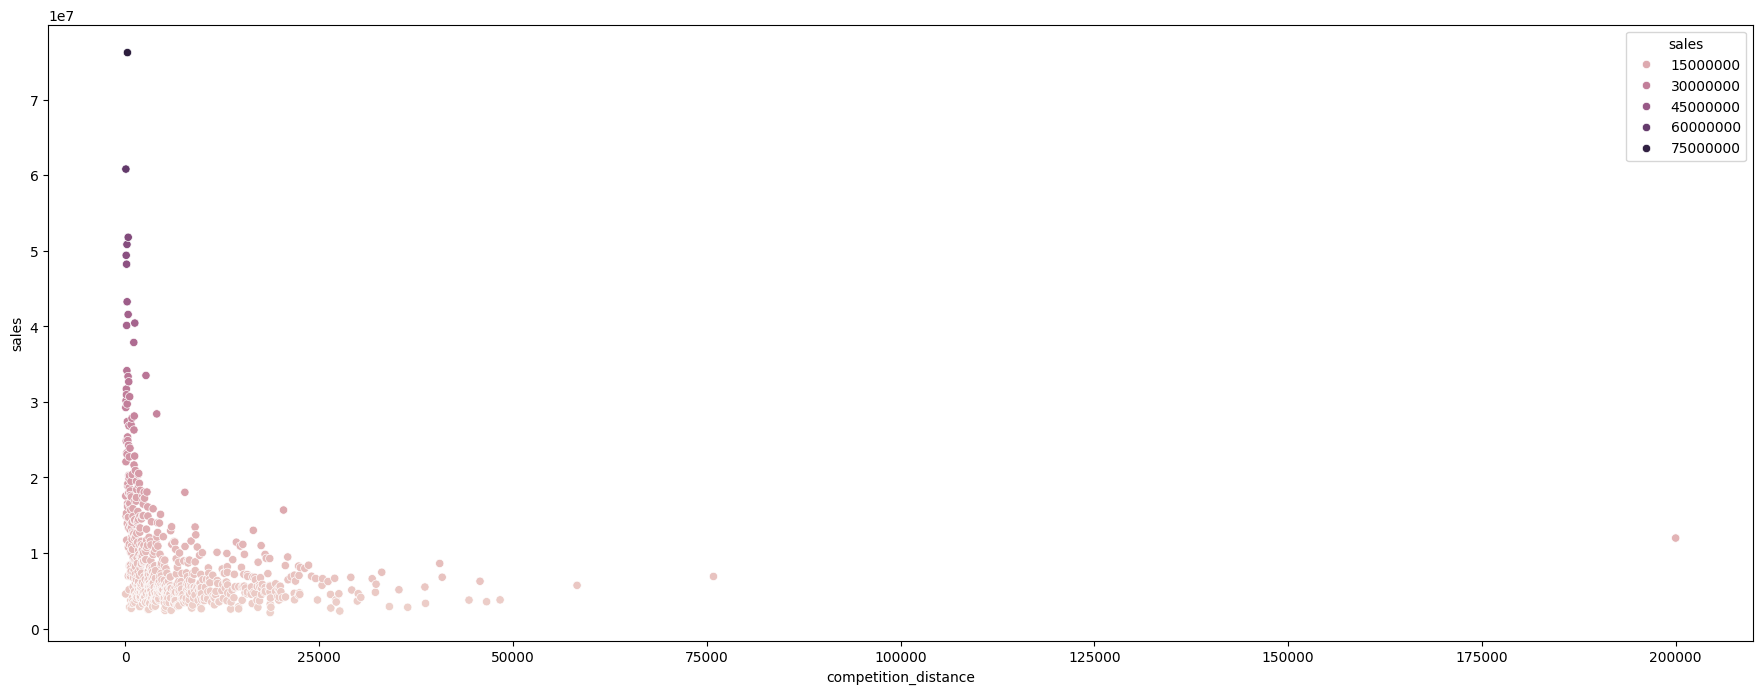

In [183]:
# Fazendo graficos com o scatterplot

aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
plt.figure(figsize=(22, 8))
sns.scatterplot(x='competition_distance', y='sales', data=aux1, hue='sales');


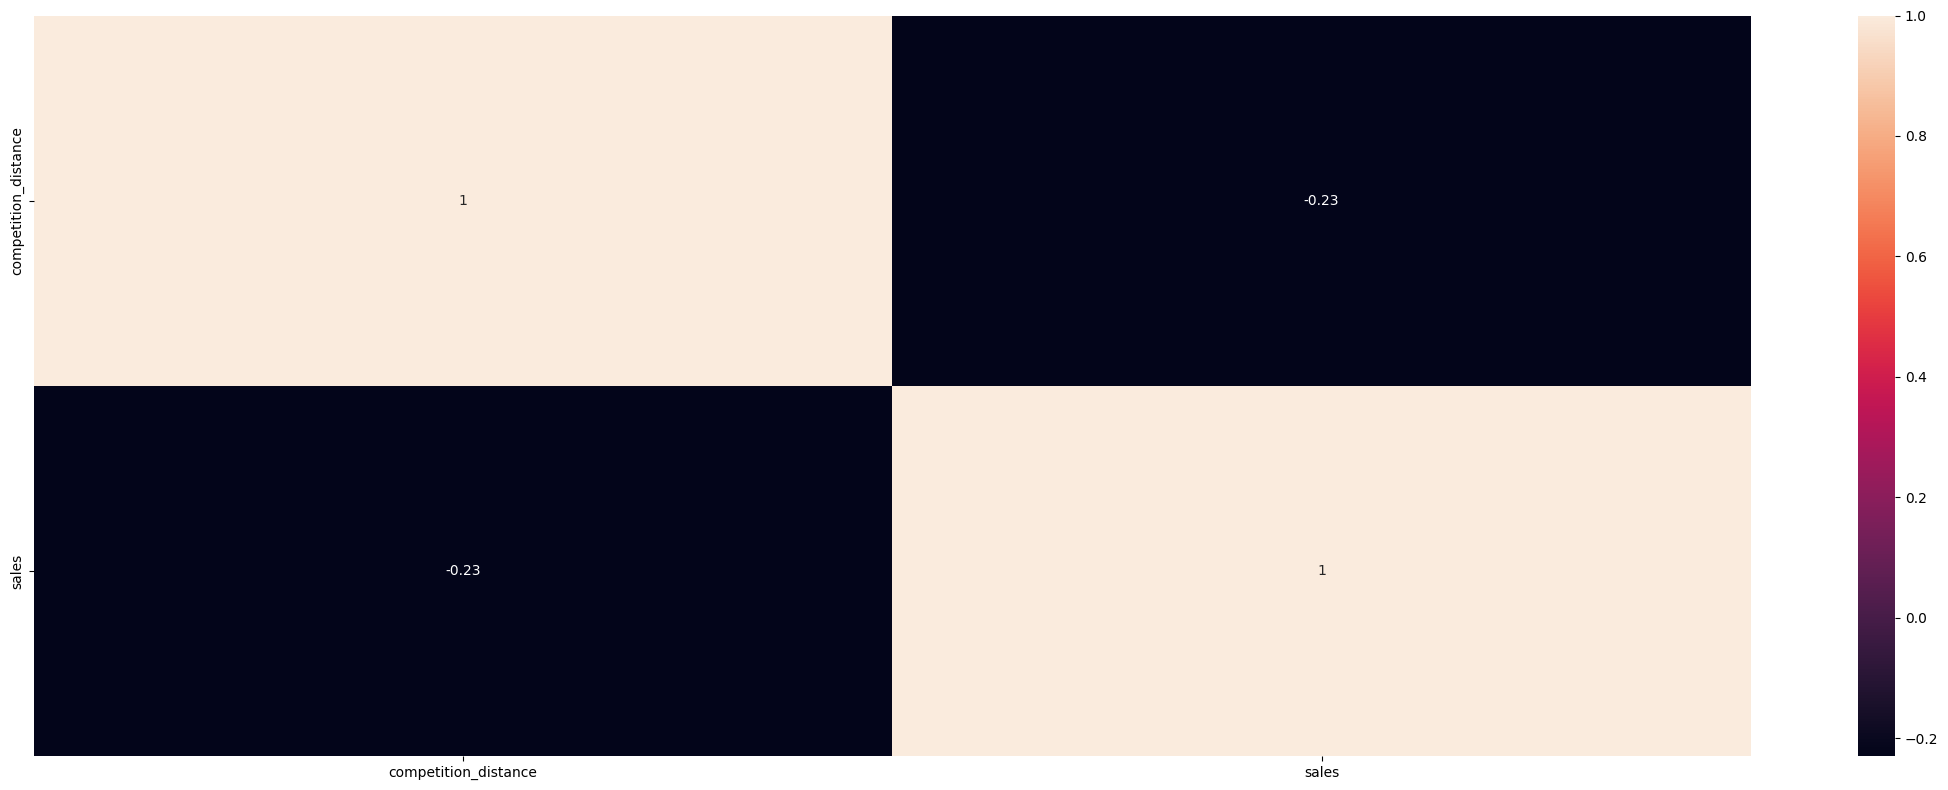

In [184]:
plt.figure(figsize=(22, 8))

sns.heatmap(aux1.corr(method='pearson'), annot=True);

# Ajuste o layout para evitar sobreposição de rótulos

plt.tight_layout()

# Exiba a figura
plt.show()

### H3 Lojas com competidores à mais tempo deveriam vender mais

#### É FALSO - > Lojas com COMPETIDORES à mais tempo VENDEM MENOS

In [185]:
aux1 = df4[['competition_time_month', 'sales']].groupby(['competition_time_month']).sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0 )]

plt.figure(figsize=(22, 8))

#sns.barplot(x='competition_open_since_month', y='sales', data=aux1, hue='competition_open_since_month' )

fig = px.bar(aux2, x='competition_time_month', y='sales', color='competition_time_month')

# Atualize o layout do gráfico para evitar sobreposição de rótulos
fig.update_layout(
    xaxis=dict(tickmode='linear'),
    xaxis_title='Competicap por Mes',
    yaxis_title='Sales',
    title='Vendas por Mês de Abertura da Concorrência'
)

# Ajuste o layout para evitar sobreposição de rótulos

plt.tight_layout()

# Exiba a figura

fig.show()

<Figure size 2200x800 with 0 Axes>

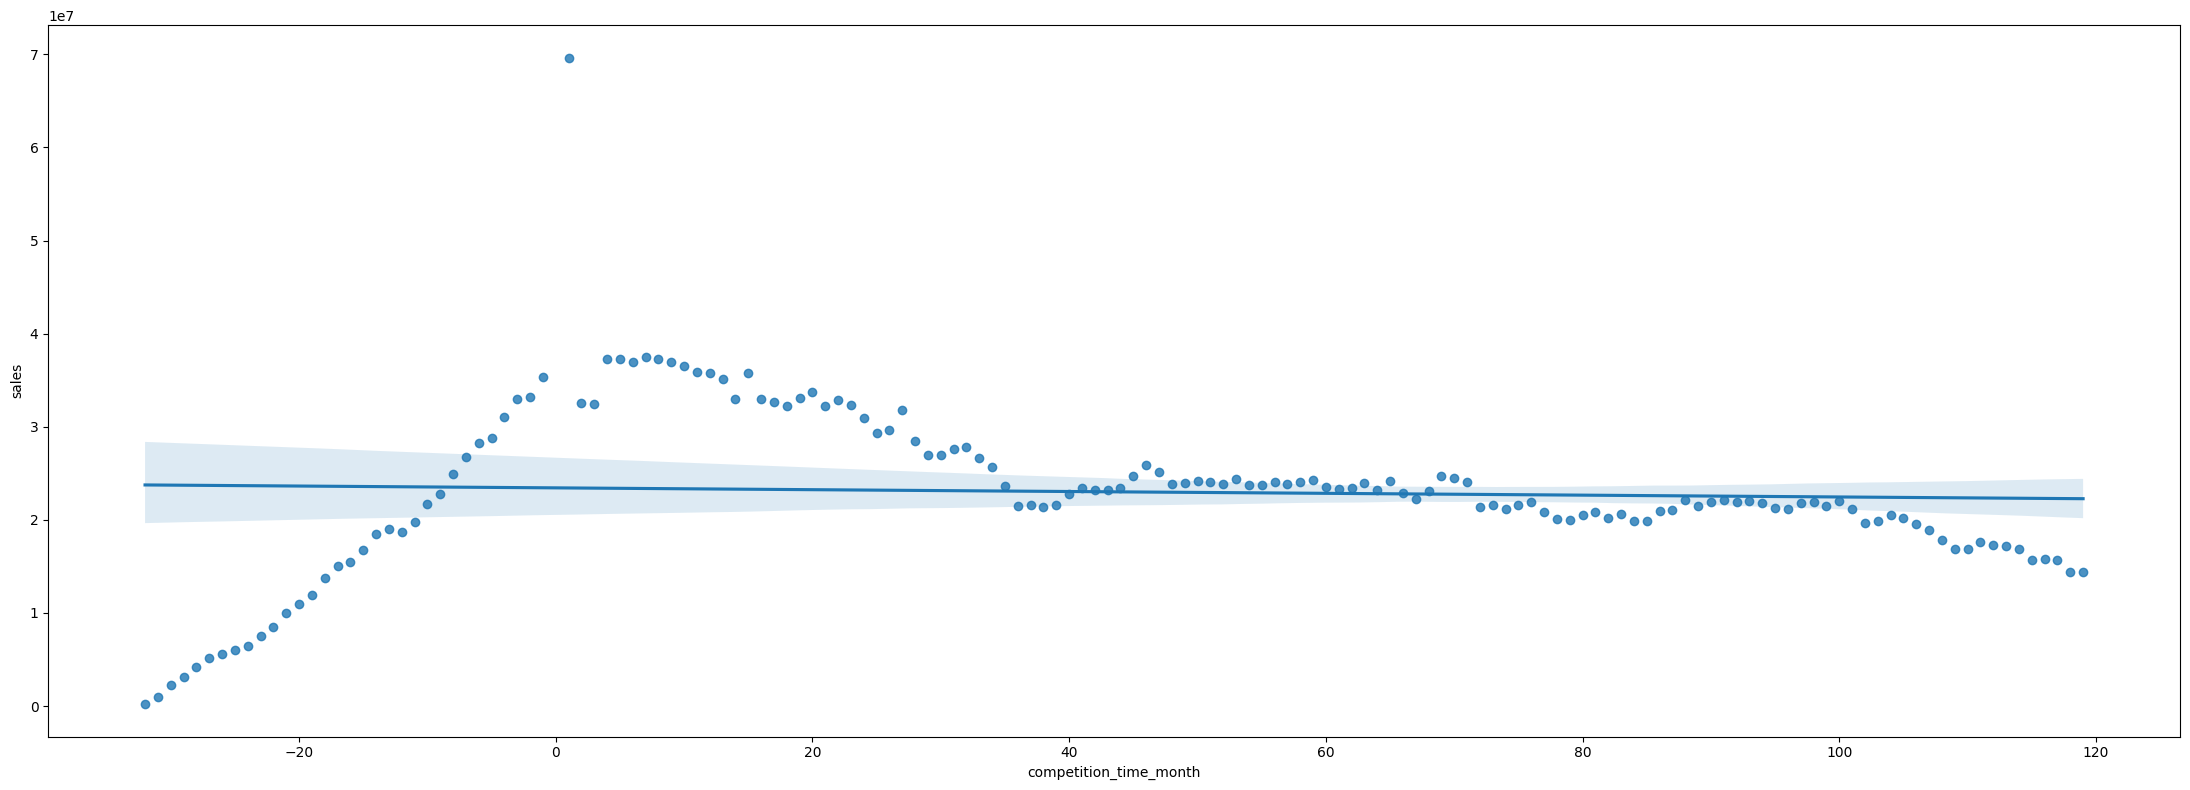

In [186]:
plt.figure(figsize=(22, 8))

sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.tight_layout()

# Exiba a figura

plt.show()

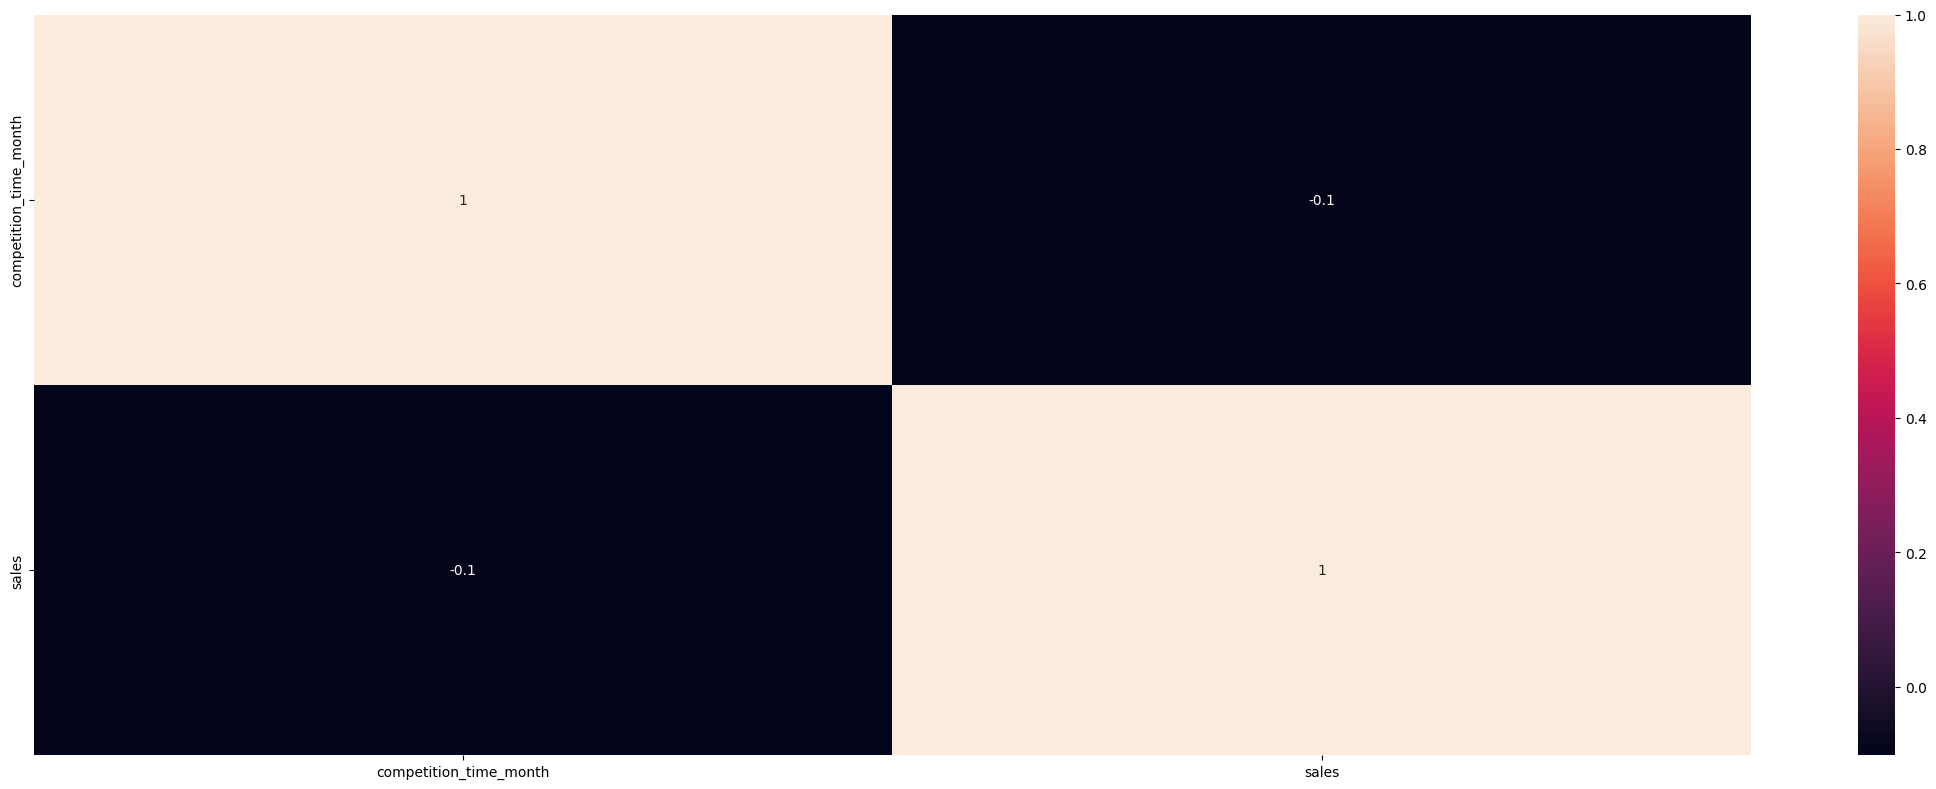

In [187]:
plt.figure(figsize=(22, 8))

sns.heatmap(aux1.corr(method='pearson'), annot=True);

# Ajuste o layout para evitar sobreposição de rótulos

plt.tight_layout()

# Exiba a figura
plt.show()

### H4 Lojas com promoções ativas por mais tempo deveriam vender mais

#### **FALSA** Lojas com promocoes ativas por mais tempo vendem menos, depois de um certo periodo de promoção

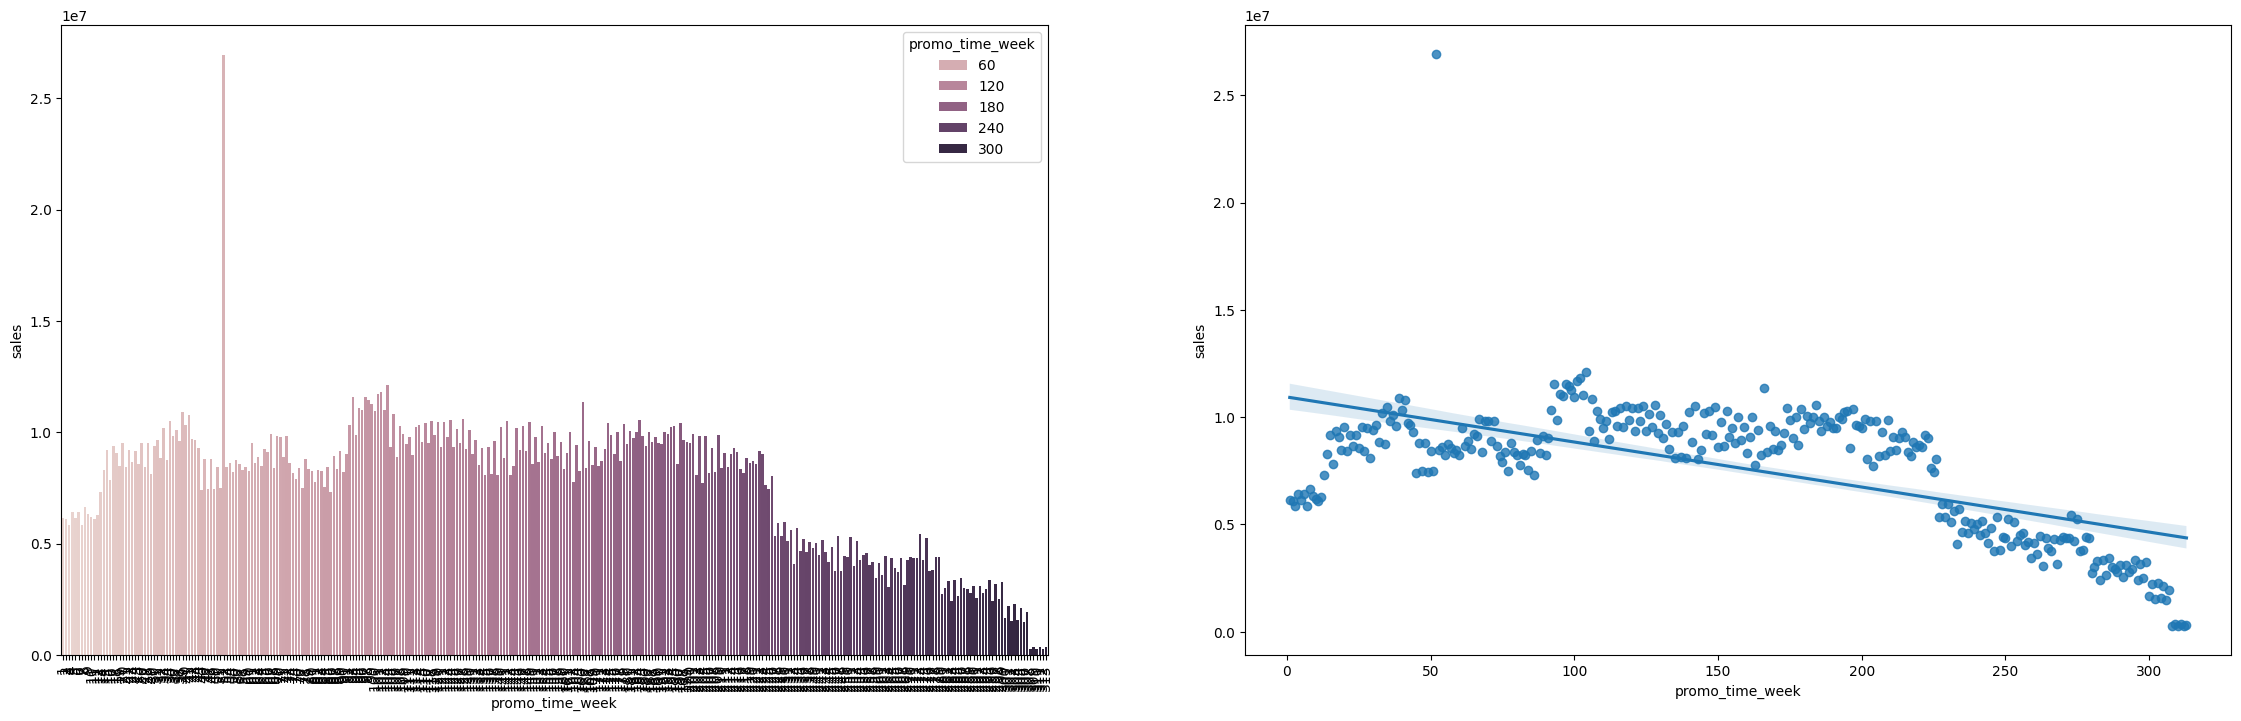

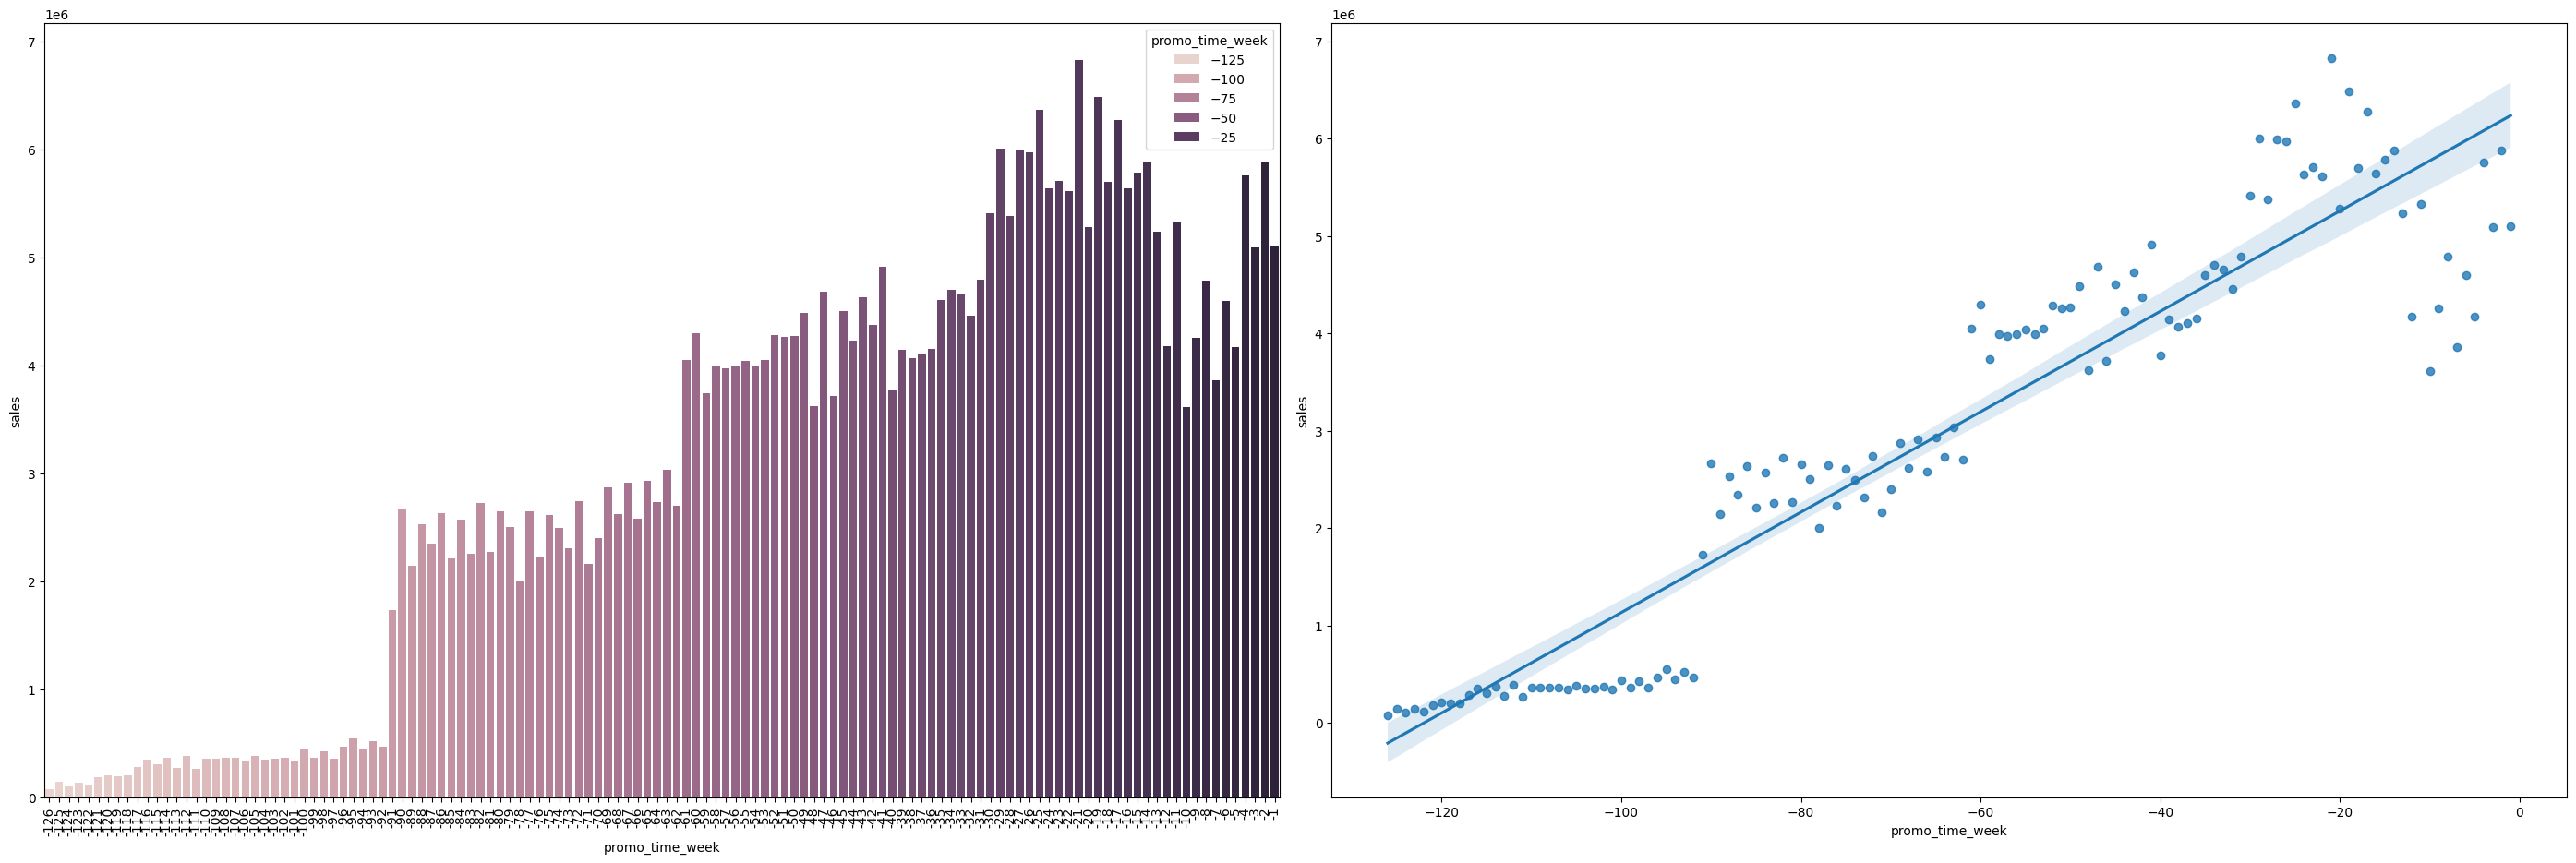

In [188]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

plt.figure(figsize=(28, 18))
plt.subplot(2,2,1)

aux2 = aux1[aux1['promo_time_week'] > 0 ] # promo extendida
sns.barplot(x='promo_time_week', y='sales', data=aux2, hue='promo_time_week')
plt.xticks(rotation=90);


plt.subplot(2,2,2)
sns.regplot(x='promo_time_week', y='sales', data=aux2)

plt.figure(figsize=(28, 18))
plt.subplot(2,2,3)

aux3 = aux1[aux1['promo_time_week'] < 0 ] # promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3, hue='promo_time_week')
plt.xticks(rotation=90);

plt.subplot(2,2,4)
sns.regplot(x='promo_time_week', y='sales', data=aux3)

# Ajuste o layout para evitar sobreposição de rótulos
plt.tight_layout()

# Exiba a figura
plt.show()

<Axes: >

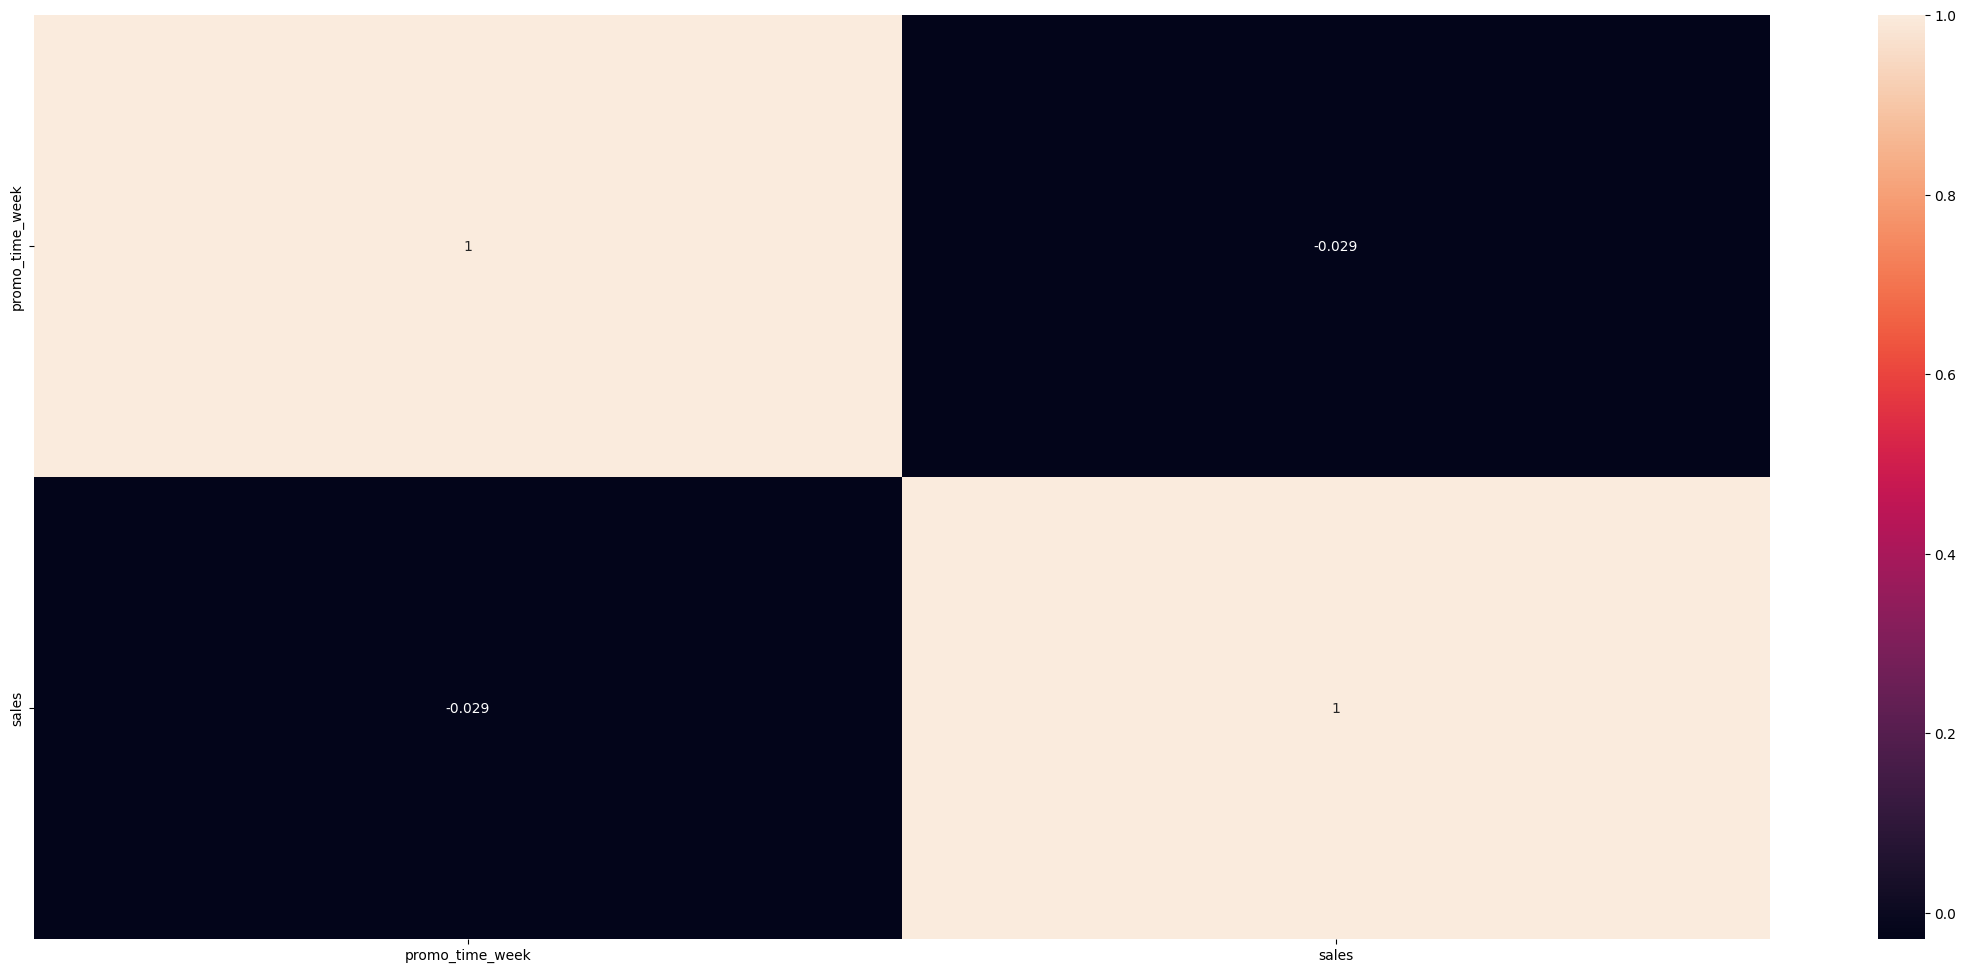

In [189]:
plt.figure(figsize=(28, 12))
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### H5 Lojas com mais dias de promoção deveriam vender mais (Faremos uma segunda analise mais para frente)

### H6 Lojas com mais promoções consecutivas deveriam vender mais
#### **FALSA** Lojas com promocoes consecutivas vendem menos

In [190]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

# Veja que neste quadro as lojas que participaram somente da promo e não participaram da promo2 se sairam melhores em vendas

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


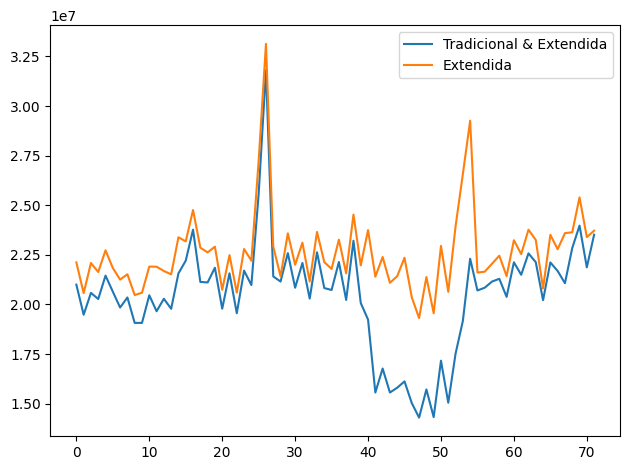

In [191]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby(['year_week']).sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby(['year_week']).sum().reset_index()
aux2.plot(ax = ax)
ax.legend(labels=['Tradicional & Extendida', 'Extendida'])

# Ajuste o layout para evitar sobreposição de rótulos
plt.tight_layout()

# Exiba a figura
plt.show()

### H8 - Lojas abertas durante o feriado de Natal deveriam vender mais
#### **FALSA** Lojas abertas durante o Natal VENDEM MENOS

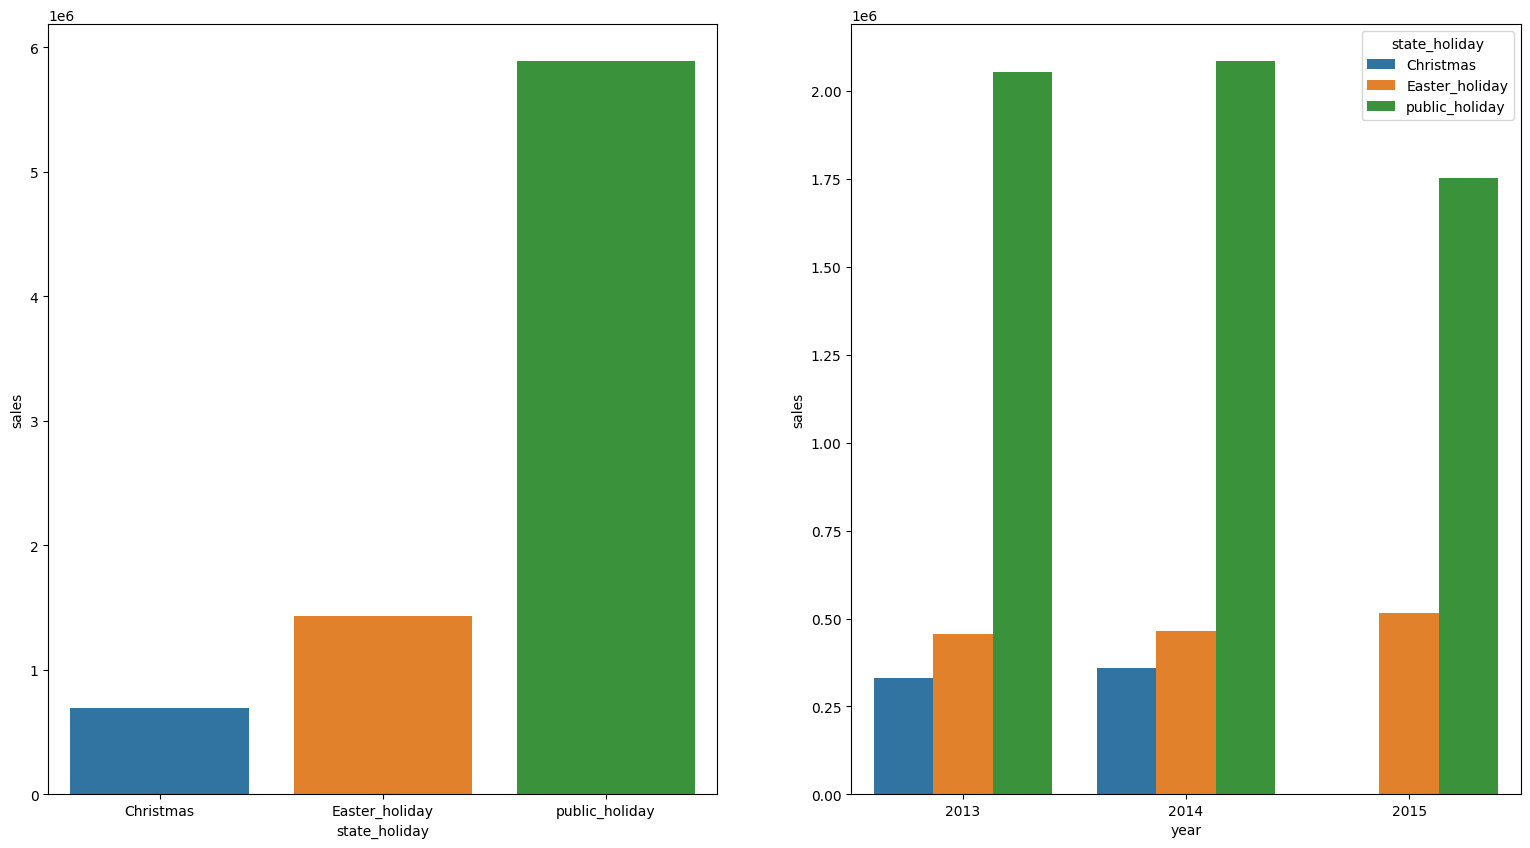

In [192]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.figure(figsize=(19, 10))
plt.subplot(1,2,1)
aux1 = aux[['state_holiday', 'sales']].groupby(['state_holiday']).sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1, hue='state_holiday');

#plt.figure(figsize=(19, 10))
plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', data=aux2, hue='state_holiday');

### H9 - Lojas deveriam vender mais ao longo dos anos
#### **FALSA** Lojas vendem menos ao passar dos anos

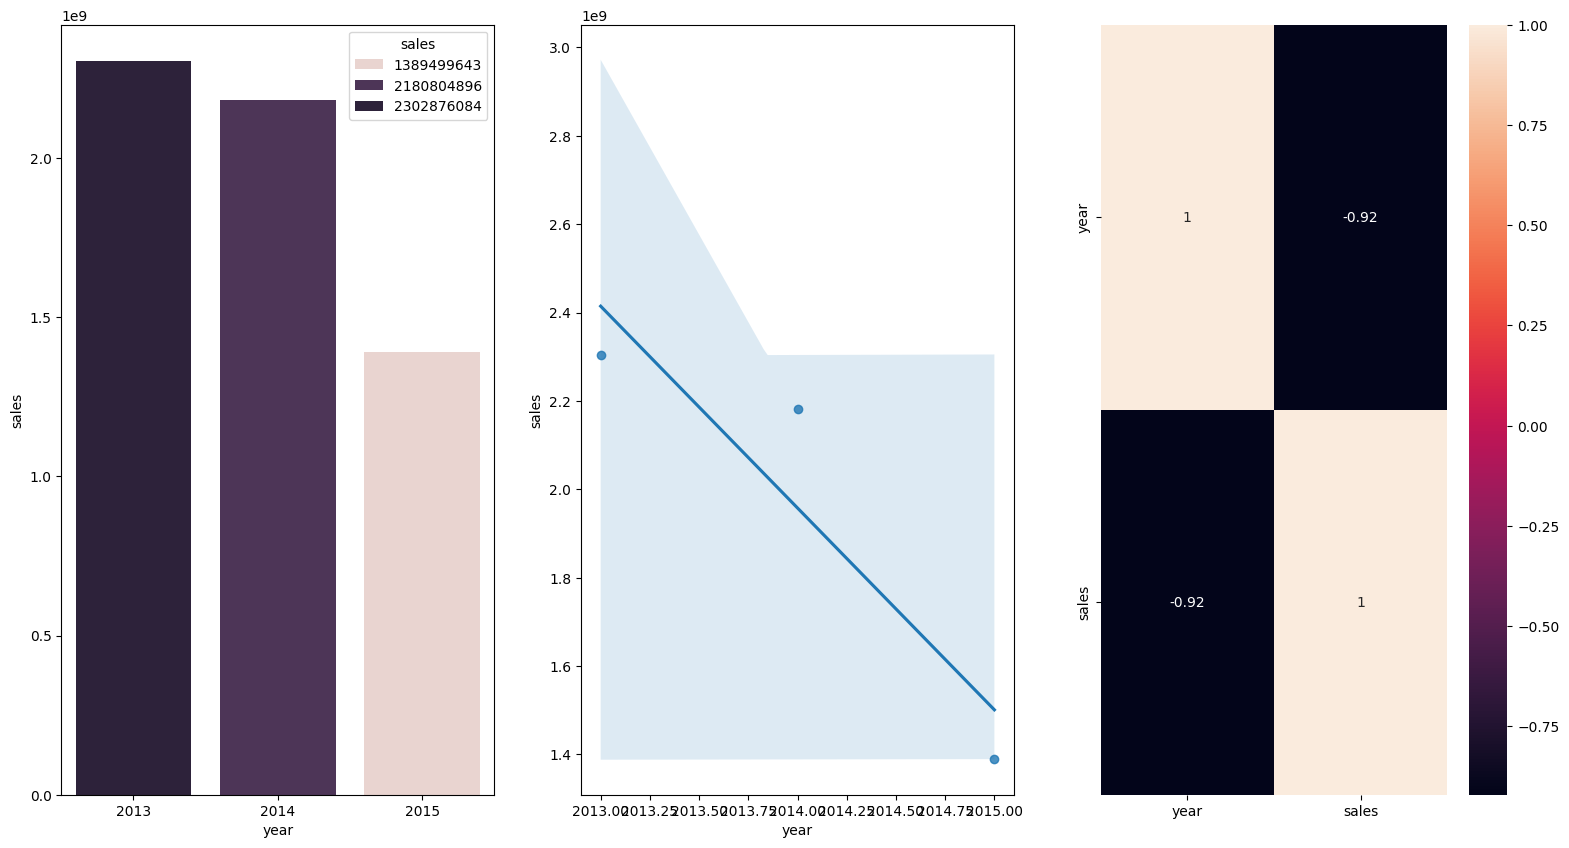

In [193]:
aux1 = df4[['year', 'sales']].groupby(['year']).sum().reset_index()


plt.figure(figsize=(19, 10))
plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1, hue='sales');

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr (method='pearson'), annot=True);

### H10 - Lojas deveriam vender mais no segundo semestre do ano
#### **FALSO** Lojas vendem menoss no 2 semestre do ano

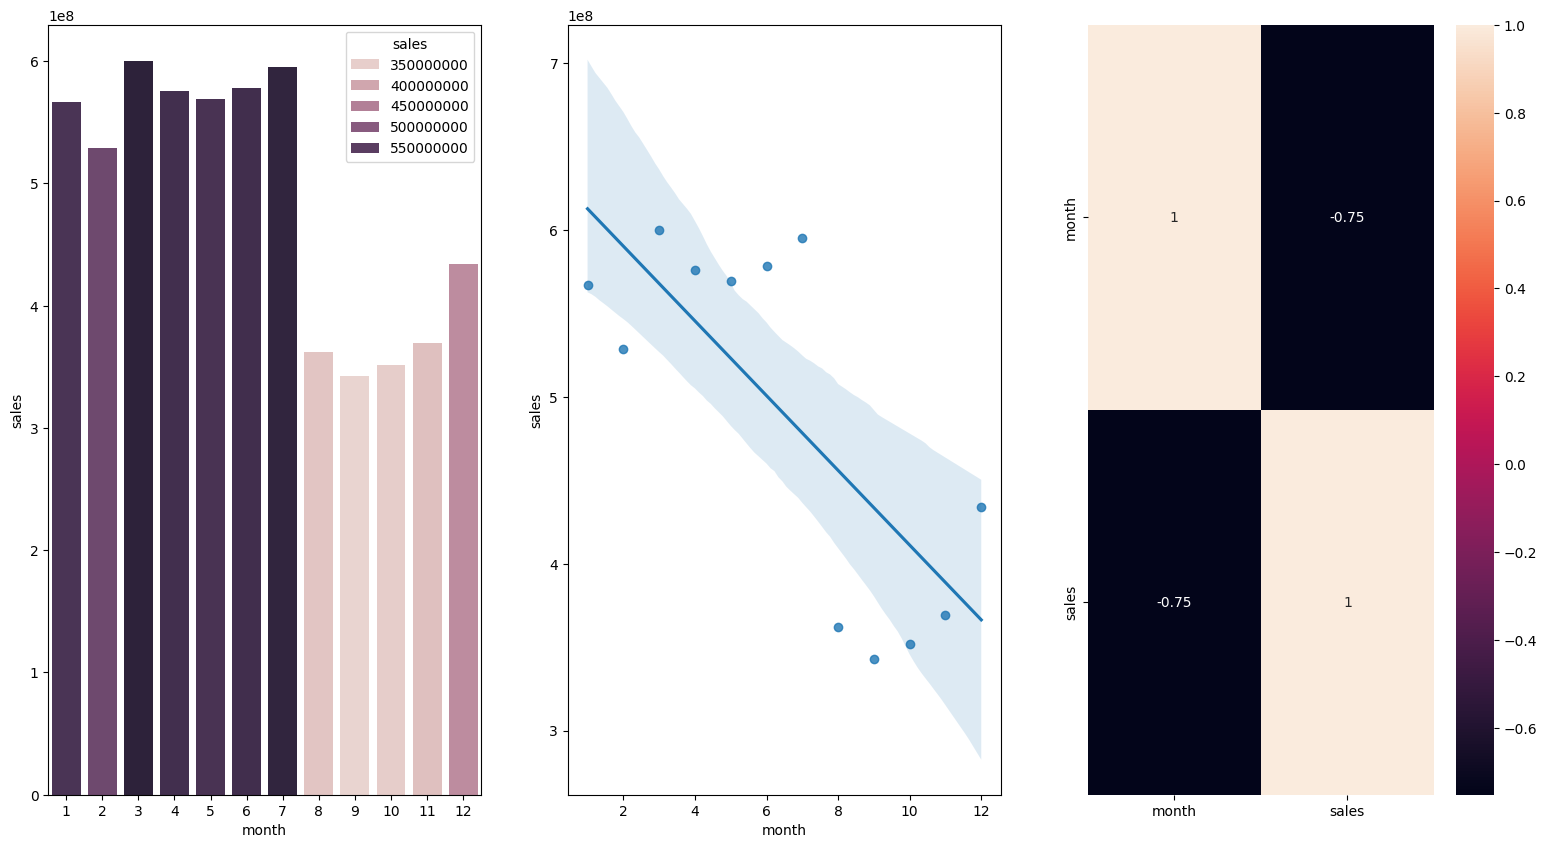

In [194]:
aux1 = df4[['month', 'sales']].groupby(['month']).sum().reset_index()


plt.figure(figsize=(19, 10))
plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1, hue='sales');

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr (method='pearson'), annot=True);

### H11 - Lojas deveriam vender mais depois do dia 10 de cada mês
### **VERDADEIRO** - lojas vendem mais depois do dia 10 de cada mês

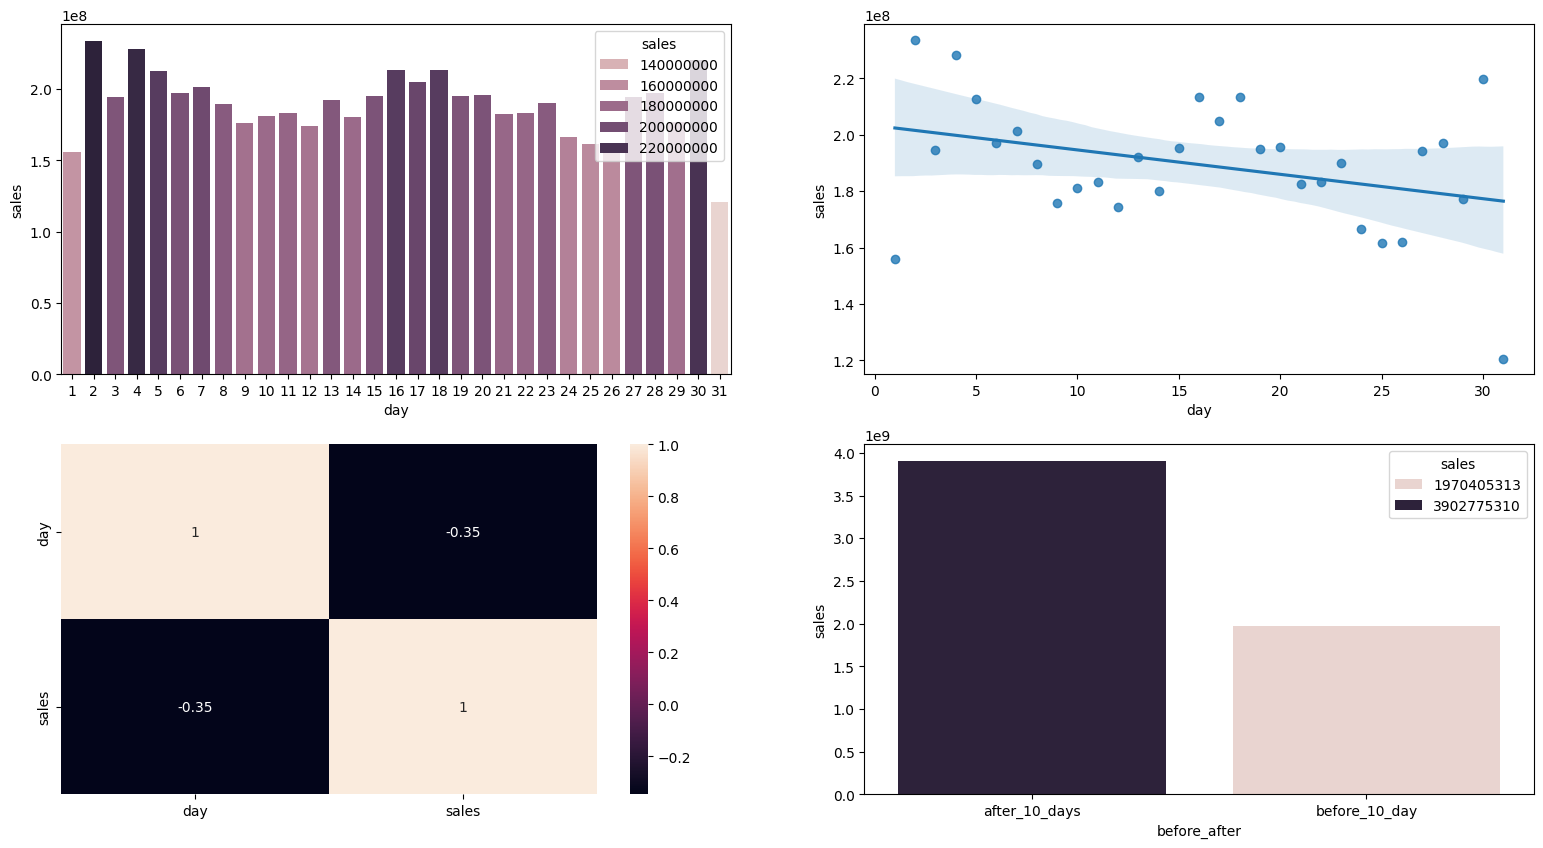

In [195]:
aux1 = df4[['day', 'sales']].groupby(['day']).sum().reset_index()


plt.figure(figsize=(19, 10))
plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1, hue='sales');

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr (method='pearson'), annot=True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_day' if x <= 10 else 'after_10_days' )
aux2 = aux1[['before_after', 'sales']].groupby(['before_after']).sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales', data=aux2, hue='sales');


### H12 - Lojas deveriam vender menos aos finais de semana
#### **VERDADEIRA** - Lojas vendem menos nos finais de semana

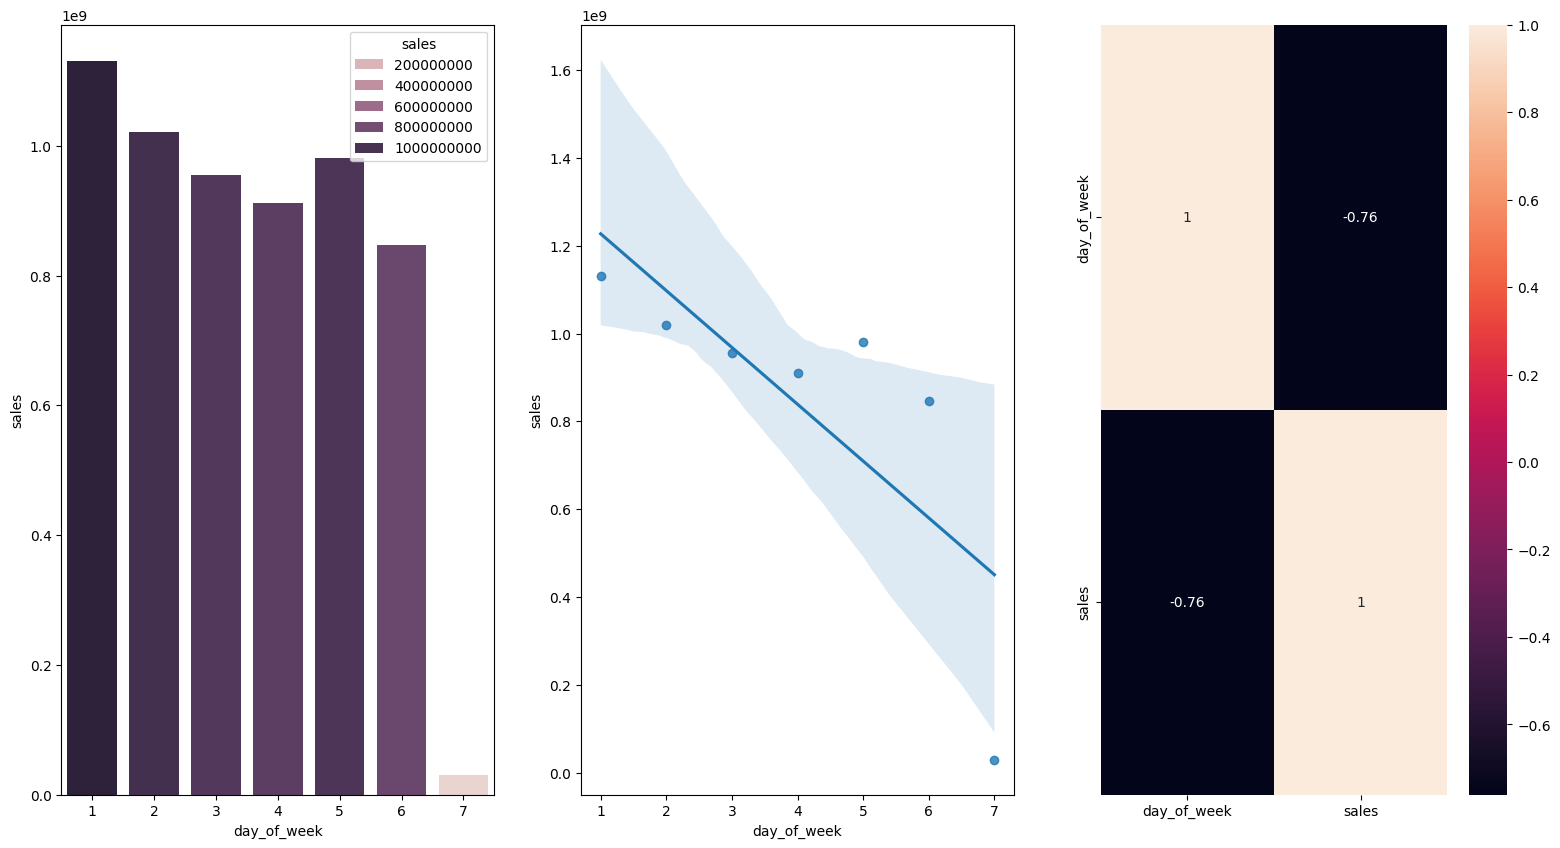

In [196]:
aux1 = df4[['day_of_week', 'sales']].groupby(['day_of_week']).sum().reset_index()


plt.figure(figsize=(19, 10))
plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1, hue='sales');

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr (method='pearson'), annot=True);

### H13 - Lojas deveriam vender menos durante os feriados escolares
#### **VERDADEIRA** - Lojas vendem menos durante os feriados escolares, exceto os meses de Julho e Agosto

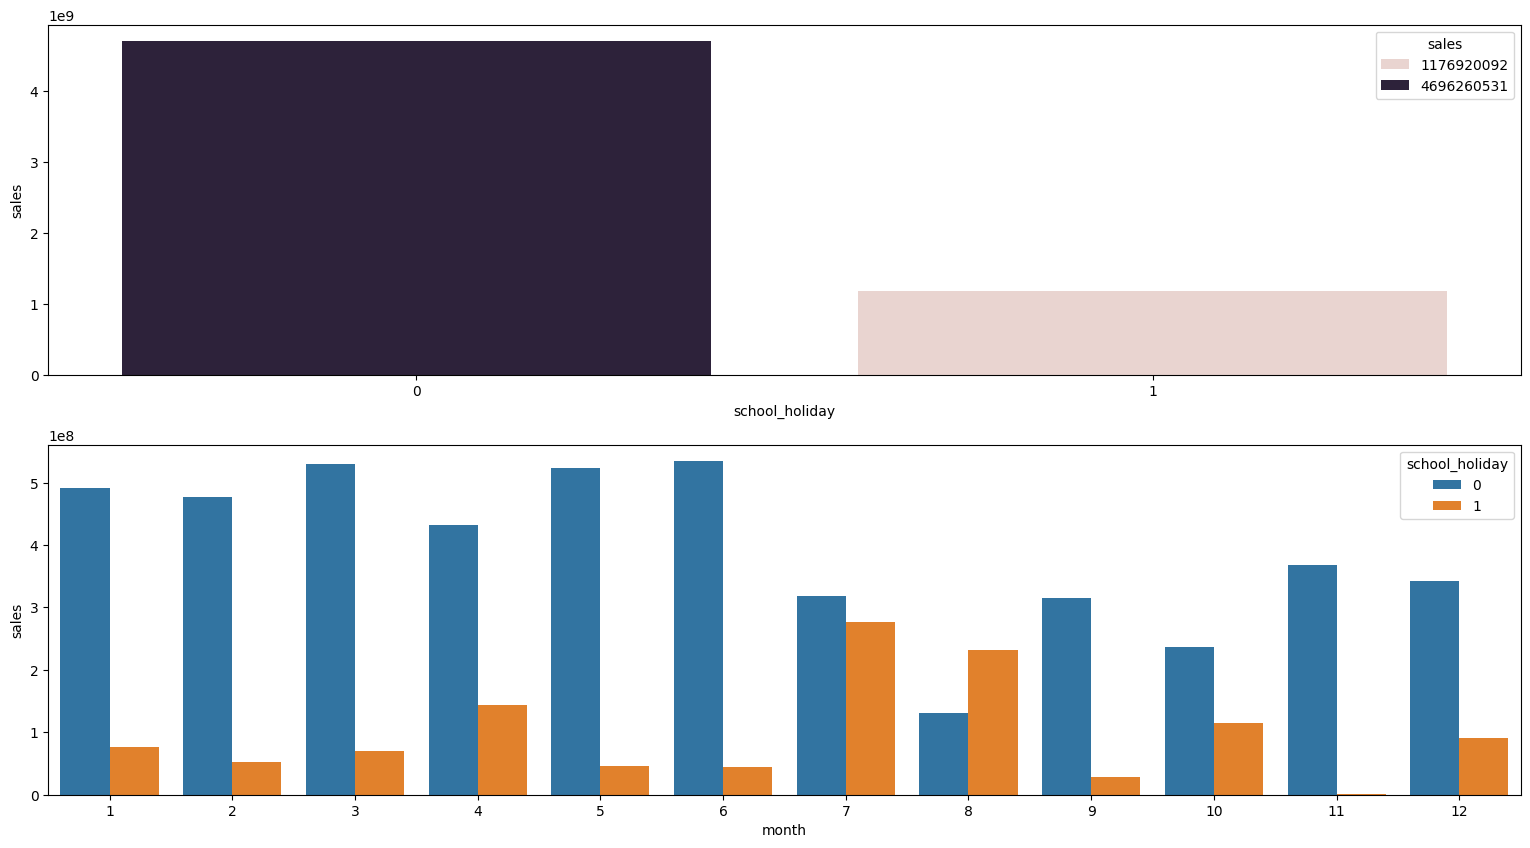

In [197]:
aux1 = df4[['school_holiday', 'sales']].groupby(['school_holiday']).sum().reset_index()


plt.figure(figsize=(19, 10))
plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux1, hue='sales');

plt.subplot(2,1,2)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', data=aux2, hue='school_holiday');

In [198]:
from tabulate import tabulate

tab = [['Hipoteses', 'Conclusao', 'Relevancia' ],
       ['H1', 'Falsa', 'Baixa'],
       ['H2', 'Falsa', 'Media'],
       ['H3', 'Falsa', 'Media'],
       ['H4', 'Falsa', 'Baixa'],
       ['H5', '-', '-'],
       ['H7', 'Falsa', 'Baixa'],
       ['H8', 'Falsa', 'Media'],
       ['H9', 'Falsa', 'Alta'],
       ['H10', 'Falsa', 'Alta'],
       ['H11', 'Verdadeira', 'Alta'],
       ['H12', 'Verdadeira', 'Alta'],
       ['H13', 'Verdadeira', 'Baixa'],
       ]
print(tabulate(tab, headers='firsthow'))


f          i           r
---------  ----------  ----------
Hipoteses  Conclusao   Relevancia
H1         Falsa       Baixa
H2         Falsa       Media
H3         Falsa       Media
H4         Falsa       Baixa
H5         -           -
H7         Falsa       Baixa
H8         Falsa       Media
H9         Falsa       Alta
H10        Falsa       Alta
H11        Verdadeira  Alta
H12        Verdadeira  Alta
H13        Verdadeira  Baixa


## 4.3 Analise Multivariada

#### 4.3.1 Atributos Numericos

In [199]:
num_attributes.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,1,5,5263,555,1,1,1,1270.0,9,2008,0,31,2015,0
1,2,5,6064,625,1,1,1,570.0,11,2007,1,13,2010,1
2,3,5,8314,821,1,1,1,14130.0,12,2006,1,14,2011,1
3,4,5,13995,1498,1,1,1,620.0,9,2009,0,31,2015,0
4,5,5,4822,559,1,1,1,29910.0,4,2015,0,31,2015,0


<Axes: >

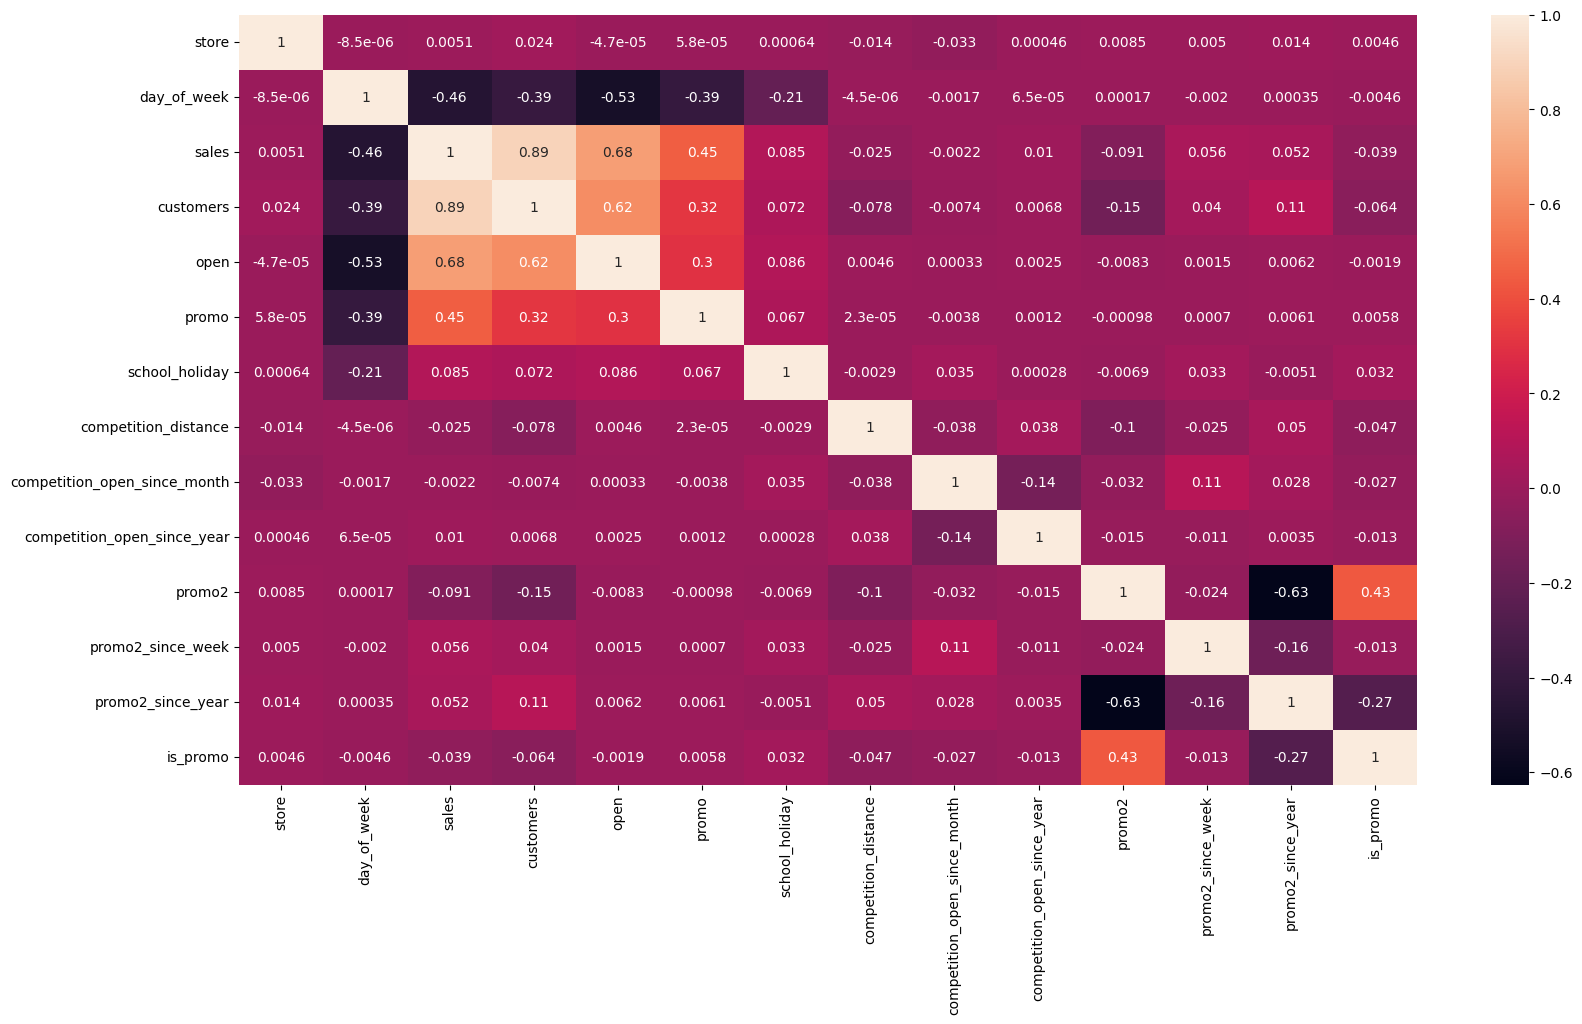

In [200]:
correlation = num_attributes.corr(method='pearson')
plt.figure(figsize=(19, 10))
sns.heatmap(correlation, annot=True)

#### 4.3.2 Variaveis Categoricas

In [201]:
cm = pd.crosstab(a['state_holiday'], a ['store_type']).to_numpy()
chi2 = stats.chi2_contingency(cm)

In [202]:
def cramer_v(x, y):
    cm = pd.crosstab(x,y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max (0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt((chi2corr / n) / (min(kcorr-1, rcorr-1 )))

In [203]:
a = df4.select_dtypes(include='object')

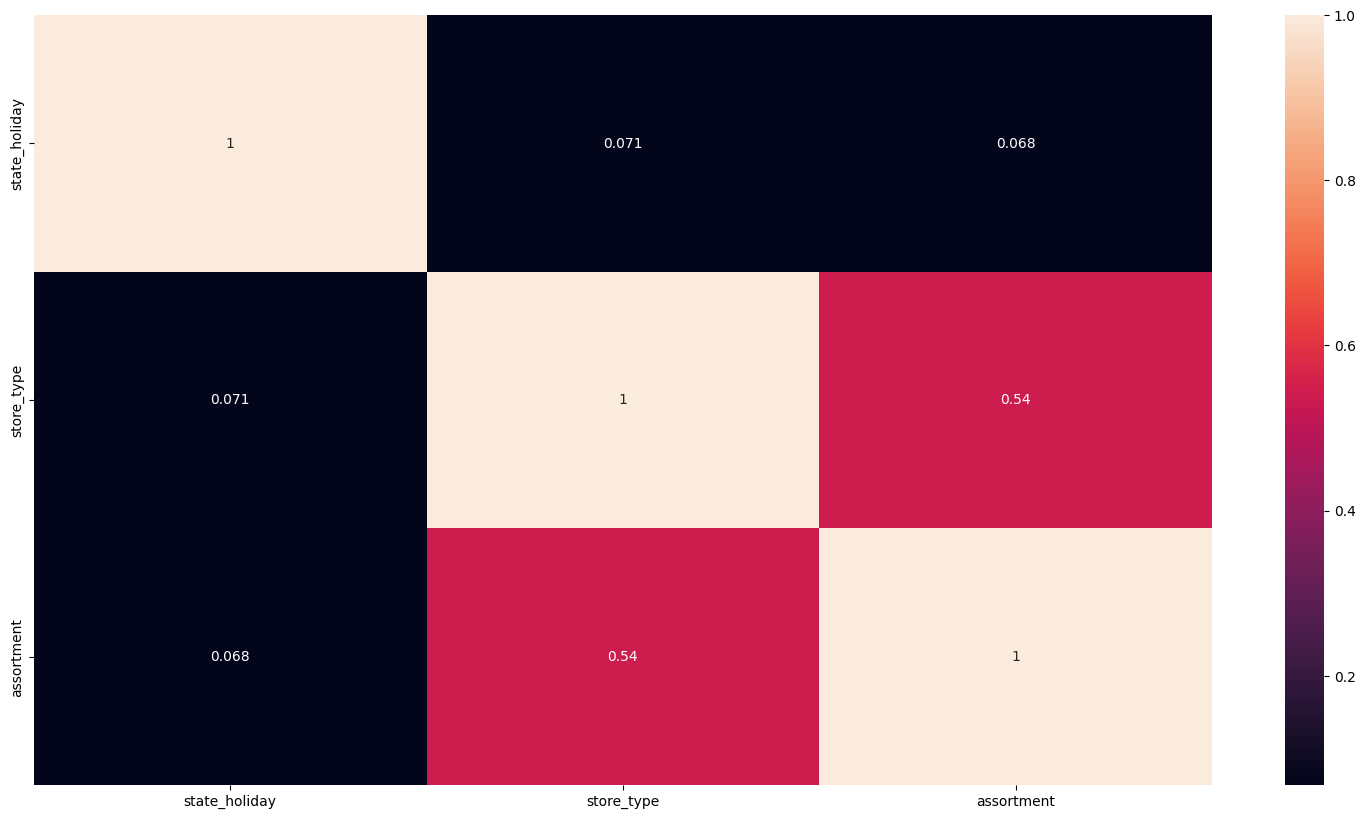

In [204]:
a1 = cramer_v(a['state_holiday'],a['state_holiday'])
a2 = cramer_v(a['state_holiday'],a['store_type'])
a3 = cramer_v(a['state_holiday'],a['assortment'])

a4 = cramer_v(a['store_type'],a['state_holiday'])
a5 = cramer_v(a['store_type'],a['store_type'])
a6 = cramer_v(a['store_type'],a['assortment'])

a7 = cramer_v(a['assortment'],a['state_holiday'])
a8 = cramer_v(a['assortment'],a['store_type'])
a9 = cramer_v(a['assortment'],a['assortment'])

d = pd.DataFrame({'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9]})
d = d.set_index(d.columns)

plt.figure(figsize=(19, 10))
sns.heatmap(d, annot=True);

# 5.0 Passo 5 - Preparacao dos Dados

In [205]:
df5 = df4.copy()

## 5.1 - Normalizacao

In [206]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values)

# year
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values)

# competition time month
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# promo week
df5['year'] = mms.fit_transform(df5[['year']].values)

C:\Users\jcmaz\AppData\Local\Temp\ipykernel_4792\4082983635.py:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




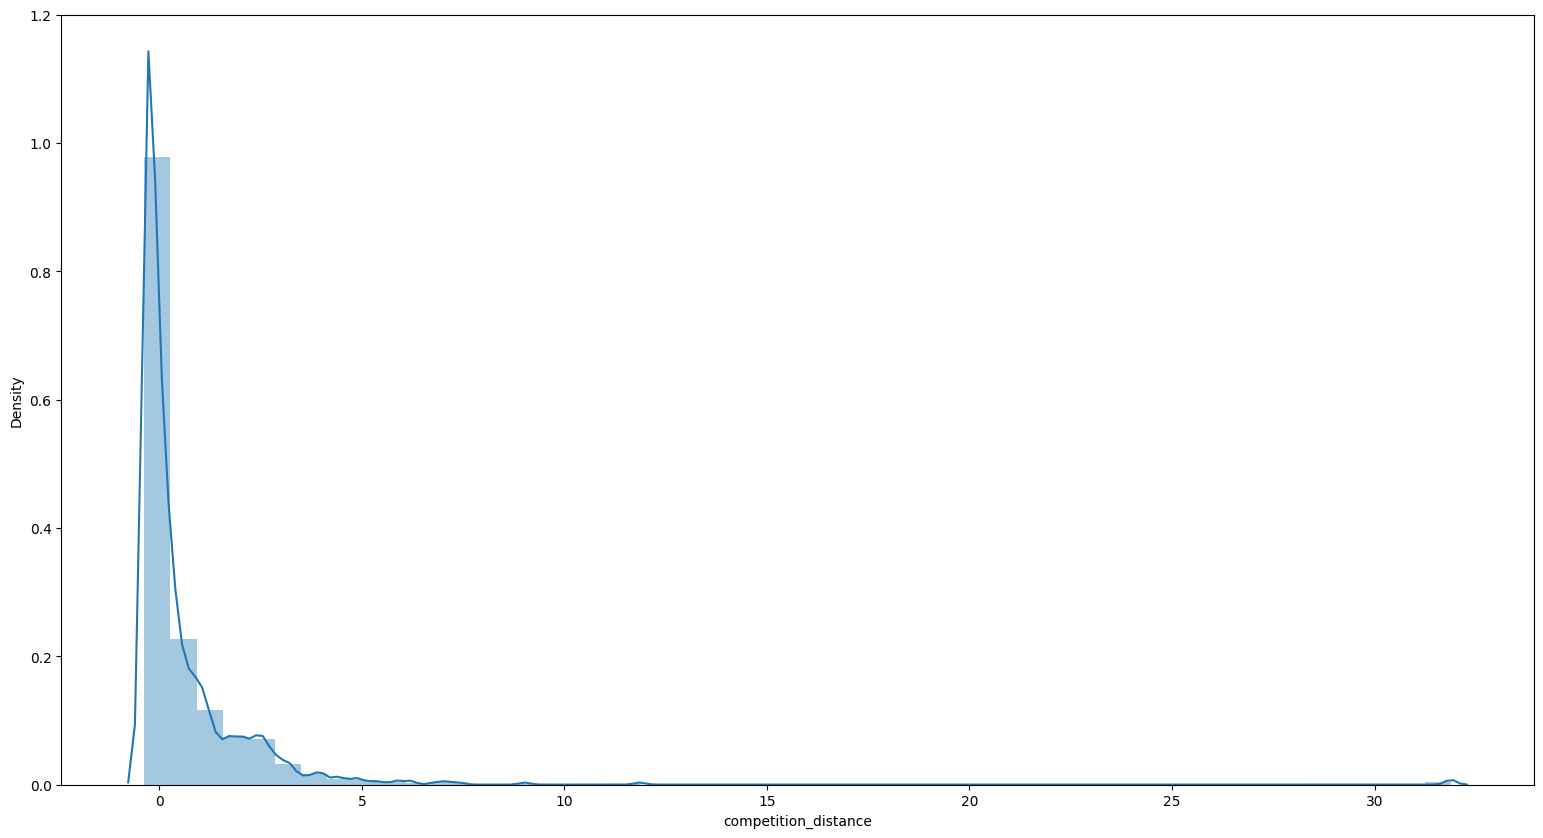

In [207]:
plt.figure(figsize=(19, 10))
sns.distplot(df5['competition_distance']);

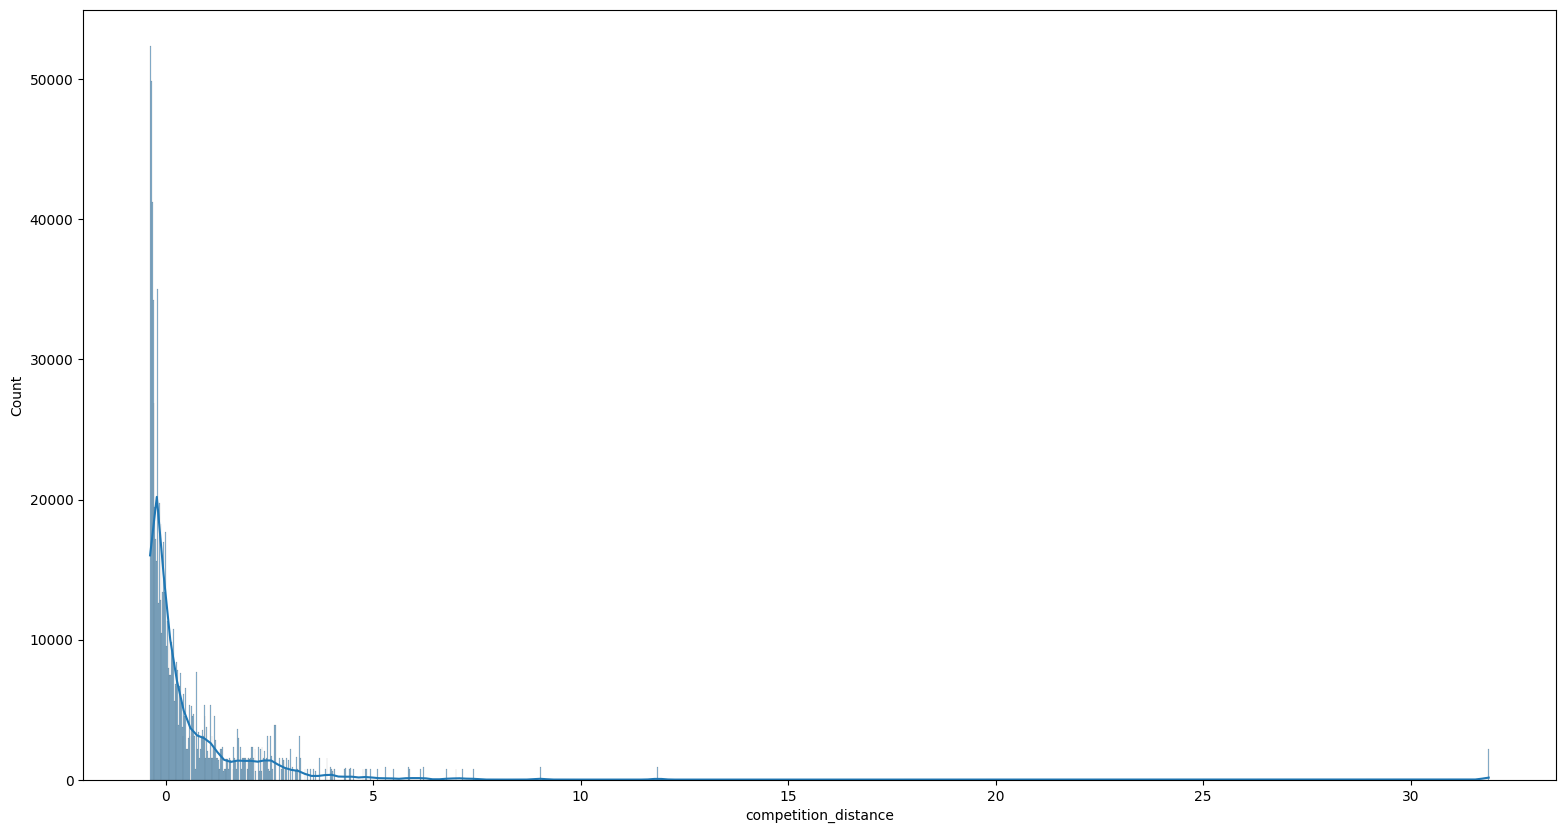

In [208]:
plt.figure(figsize=(19, 10))
sns.histplot(df5['competition_distance'], kde=True)  # Use kde=True para adicionar uma estimativa de densidade de kernel (opcional)
plt.show()

## 5.2 - Rescaling

In [209]:
# month
# day
# week of year
# day of week

## 5.3 - Transformacao

### 5.3.1 - Encoding

In [211]:
# state_holiday - One Hot Encoding

df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding

le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment - Ordinal Encoding

assortment_dict = {'basic':1 , 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

In [224]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,day,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_Christmas,state_holiday_Easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,...,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,False,False,False,True
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,...,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,False,False,False,True
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,...,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,False,False,False,True
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,...,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,False,False,False,True
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,...,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,False,False,False,True
